Import relevant packages

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import json
import numpy as np
import random
import os

tf.enable_eager_execution()
#tf.compat.v1.set_random_seed(18)

/home/harvey/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/harvey/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/harvey/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/harvey/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

Set up data loading functions.

In [2]:
tf.__version__

'1.14.0'

In [7]:
# One shot learning - Each network takes input and output and tries to compare if two tasks are the same.
Xt = []
Yt = []
Xv = []
Yv = []

rng = np.random.default_rng()

def load(name):
    with open(name) as json_file:
        data = json.load(json_file) 
        ctraintask = []
        cvaltask = []
        l = len(data['train'])
        i = 0
        for t in data['train']:
            i += 1
            cin = np.array(t['input'])
            cinr = np.full((30, 30), -1)
            cinr[:cin.shape[0], :cin.shape[1]] = cin
            cout = np.array(t['output'])
            coutr = np.full((30, 30), -1)
            coutr[:cout.shape[0], :cout.shape[1]] = cout
            cX = np.concatenate((cinr, coutr))
            if not i == l:
                ctraintask.append(cX)
                Yt.append(name)
            else:
                cvaltask.append(cX)
                Yv.append(name)
        Xt.append(np.array(ctraintask))
        Xv.append(np.array(cvaltask))

def testAccuracy(model, N, loops):
    right = 0
    wrong = 0
    for _ in range(loops):
        basecategory = random.randint(0, Xv.shape[0]-1)
        baseTask = Xv[basecategory][0].reshape(60, 30, 1)
        baseProb = model.predict([np.array([baseTask]), np.array([Xt[basecategory][random.randint(0, Xt[basecategory].shape[0]-1)].reshape(60, 30, 1)])])[0][0]
        for i in range(0, N):
            ccategory = (basecategory+random.randint(1, Xt.shape[0]))%Xt.shape[0]
            cindex = random.randint(0, Xt[ccategory].shape[0]-1)
            ctask = Xt[ccategory][cindex] 
            cProb = model.predict([np.array([baseTask]), np.array([ctask.reshape(60, 30, 1)])])
            if cProb[0][0] > baseProb:
                wrong += 1
                break
        else:
            right += 1
    return (100*right)/loops

def getBatch(batchsize, training):
    if training:
        X = Xt
        Y = Yt
    else:
        X = Xv
        Y = Yv
    categories = rng.choice(X.shape[0], size=(batchsize,), replace=False)
    targets = np.zeros((batchsize,))
    targets[batchsize//2:] = 1
    pairs=[np.zeros((batchsize, 60, 30, 1)) for i in range(2)]
    for i in range(batchsize):
        category = categories[i]
        pairs[0][i,:,:,:] = X[category][random.randint(0, X[category].shape[0]-1)].reshape(60, 30, 1)
        if i >= batchsize // 2:
            category_2 = category
        else:
            category_2 = (category + random.randint(1, X.shape[0])) % X.shape[0] 
        pairs[1][i,:,:,:] = X[category_2][random.randint(0, X[category_2].shape[0]-1)].reshape(60, 30, 1)
    return pairs, targets

def generate(batchsize, training):
    while True:
        pairs, targets = getBatch(batchsize, training)
        yield (pairs, targets)

Load data.

In [9]:
with os.scandir('training/') as entries:
    for entry in entries:
        load("training/"+entry.name)

with os.scandir('test/') as entries:
    for entry in entries:
        load("test/"+entry.name)

Xt = np.array(Xt)
Xv = np.array(Xv)
Yt = np.array(Yt)
Yv = np.array(Yv)

Define model.

In [10]:
# This function is based off the example in this tutorial: https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d
def get_siamese_model(input_shape):
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    model = Sequential()
    model.add(Conv2D(64, (10,10), padding="same", activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), padding="same", activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), padding="same", activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), padding="same", activation='relu'))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid'))

    encoded_l = model(left_input)
    encoded_r = model(right_input)
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

    return siamese_net

Train model.

In [320]:
model = get_siamese_model((60, 30, 1))
print(model.summary())
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy", optimizer=optimizer)
print(testAccuracy(model, 10, 18))

def trainmodel(epo):
    bestAccuracy = 0

    for i in range(epo):
        model.fit_generator(generate(128, True), epochs=1, steps_per_epoch=50)
        accuracy = testAccuracy(model, 20, 18)
        if accuracy > bestAccuracy:
            model.save_weights("bestCheckpoint/best")
            bestAccuracy = accuracy
            print("New Best: "+str(bestAccuracy))

trainmodel(100)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 60, 30, 1)]  0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 60, 30, 1)]  0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 4096)         23219008    input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 4096)         0           sequential_5[1][0]         

KeyboardInterrupt: 

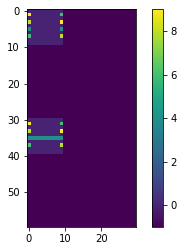

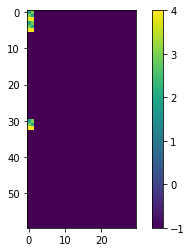

tf.Tensor([[0.]], shape=(1, 1), dtype=float32)


In [19]:
n = 12
k = 10
ctask1 = Xt[n][0].reshape(60, 30, 1)
plt.imshow(ctask1.reshape(60, 30))
plt.colorbar()
plt.show()
ctask2 = Xv[k][0].reshape(60, 30, 1)
plt.imshow(ctask2.reshape(60, 30))
plt.colorbar()
plt.show()
taskin = []
taskin.append(tf.convert_to_tensor(np.array([ctask1.astype(np.float32)])))
taskin.append(tf.convert_to_tensor(np.array([ctask2.astype(np.float32)])))

print(model(taskin))

Adversarial Generation.

In [25]:
import matplotlib.pyplot as plt
model = get_siamese_model((60, 30, 1))
model.load_weights("bestCheckpoint/best")

In [262]:
from timeit import default_timer as timer
import random

In [291]:
#sampletask = [np.array([AI.Xt[0][0].reshape(60,30,1)]), np.array([AI.Xt[1][1].reshape(60,30,1)])]
loss_object = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

def getGradients(taskin):
    taskin[0] = tf.convert_to_tensor(taskin[0].astype(np.float32))
    taskin[1] = tf.convert_to_tensor(taskin[1].astype(np.float32))
    with tf.GradientTape() as tape:
        tape.watch(taskin)
        prediction = model(taskin)
        loss = loss_object(tf.convert_to_tensor(np.array([1]).reshape(1, 1)), prediction)
    gradient = tape.gradient(loss, taskin)
    #signs = tf.sign(gradient)
    return [gradient[1].numpy()[0][30:], loss, prediction]

def generateTask(examples, cin, l, accthresh, verbose):
    cin = cin.astype(np.float64)
    lasterr = 99999
    for i in range(1000):
        grads = np.zeros((30, 30, 1))
        err = 0
        acc = 0
        for e in examples:
            sampletask = [np.array([e]), np.array([cin.reshape(60,30,1)])]
            result = getGradients(sampletask)
            grads += result[0]
            err += result[1].numpy()
            acc += result[2].numpy()[0][0]
        grads /= len(examples)
        err /= len(examples)
        acc /= len(examples)
        grads *= l
        adjustment = np.zeros((60,30,1))
        adjustment[30:, :, :] = grads
        cin -= adjustment
        np.clip(cin, -1, 9, out=cin)
        if verbose:
            if i%100 == 0:
                print("EPOCH "+str(i)+": "+str(err)+" "+str(acc))
            if i%500 == 0:
                out = cin.reshape(60, 30)[30:, :]
                plt.imshow(out)
                plt.colorbar()
                plt.show()
        if acc*100 > accthresh:
            if verbose:
                print("STOPPING AT "+str(err))
            break
    out = cin.reshape(60, 30)[30:, :]
    return out

def generateTaskAdam(examples, cin, l, accthresh, verbose):
    cutoff = 10
    referencetasks = []
    outputtasks = []
    cin = cin.reshape(60, 30, 1)
    for e in examples:
        referencetasks.append(e)
        outputtasks.append(cin)
    referencetasks = tf.Variable(tf.convert_to_tensor(np.array(referencetasks).astype(np.float32)))
    adjusttask = tf.Variable(tf.convert_to_tensor(np.array(cin[30:, :]).astype(np.float32)))  
    outputtasks = tf.Variable(tf.convert_to_tensor(np.array(outputtasks).astype(np.float32)))
    starttime = timer()
    for i in range(1000):
        if timer()-starttime > 5:
            if verbose:
                print("MAX TIME EXCEEDED")
            break
        taskin = [referencetasks, outputtasks]
        with tf.GradientTape() as tape:
            tape.watch(taskin)
            prediction = model(taskin)
            loss = loss_object(tf.convert_to_tensor(np.array([1]*len(examples)).reshape(prediction.shape)), prediction)
        gradient = tape.gradient(loss, taskin)
        grad = np.mean(gradient[1], axis=0)[30:, :]
        opt.apply_gradients(zip([grad], [adjusttask]))
        
        outputtasks = []
        cin[30:, :] = adjusttask.numpy()
        for e in examples:
            outputtasks.append(cin)
        outputtasks = tf.Variable(tf.convert_to_tensor(np.array(outputtasks).astype(np.float32)))
        acc = np.mean(prediction)*100
        if acc > accthresh:
            if verbose:
                print("ENDING AT EPOCH "+str(i)+": "+str(np.mean(loss))+" "+str(acc))
            break
        if i%100 == 0:
            if verbose:
                print("EPOCH "+str(i)+": "+str(np.mean(loss))+" "+str(acc))
    out = cin.reshape(60, 30)[30:, :]
    return out

def generateExample(taskclass, thresh, adam):
    examples = []
    for i in range(Xt[taskclass].shape[0]):
        examples.append(Xt[taskclass][i].reshape(60,30,1).astype(np.float64))
    cin = np.array([Xv[taskclass][0].reshape(60,30,1)])
    cin[0][30:, :, :] = cin[0][:30, :, :]
    if adam:
        out = generateTaskAdam(examples, cin, 0.5, thresh, False)
    else:
        out = generateTask(examples, cin, 0.5, thresh, False)
    cout = cin[0].reshape(60, 30)
    cout[30:, :] = out
    return cout

Adversarial Loop

In [312]:
Xadv = []
Yadv = []
def genAdv(batchsize):
    X = Xt
    Y = Yt
    categories = rng.choice(X.shape[0], size=(batchsize,), replace=False)
    targets = np.zeros((batchsize,))
    pairs = [np.zeros((batchsize, 60, 30, 1)) for i in range(2)]
    for i in range(batchsize):
        category = categories[i]
        pairs[0][i, :, :, :] = X[category][random.randint(0, X[category].shape[0]-1)].reshape(60, 30, 1)
        pairs[1][i, :, :, :] = generateExample(category, 80, True).reshape(60, 30, 1)
    return pairs, targets

def getBatchMixed(batchsize, training):
    pairs1, targets1 = getBatch(batchsize//2, training)
    pairs2, targets2 = genAdv(batchsize//2)
    pairs = []
    targets = np.append(targets1, targets2)
    pairs.append(np.append(pairs1[0], pairs2[0], axis=0))
    pairs.append(np.append(pairs1[1], pairs2[1], axis=0))
    return pairs, targets

def generateMixed(batchsize, training):
    while True:
        pairs, targets = getBatchMixed(batchsize, training)
        yield (pairs, targets)

optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy", optimizer=optimizer)

Ground Truth


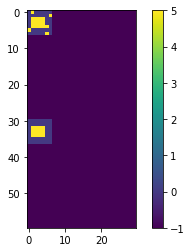

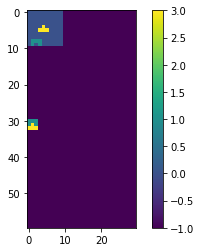

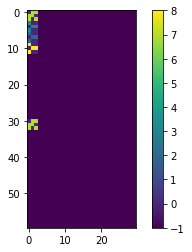

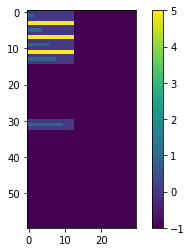

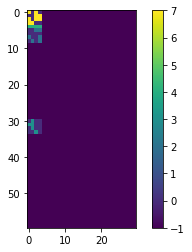

1/1 [==============================] - 302s 302s/step - loss: 0.5970
EPOCH 0 ACCURACY 72.22222222222223


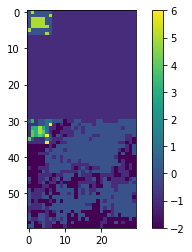

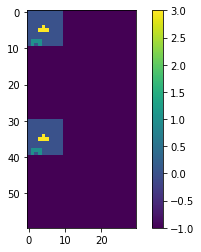

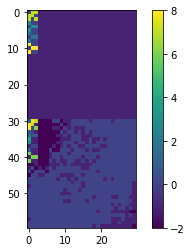

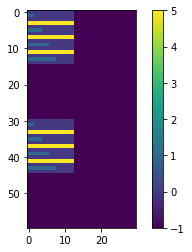

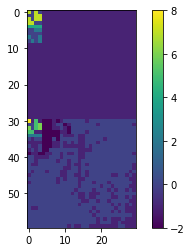

1/1 [==============================] - 323s 323s/step - loss: 0.4807
EPOCH 1 ACCURACY 77.77777777777777


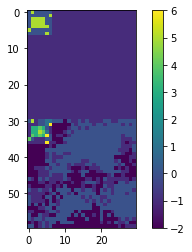

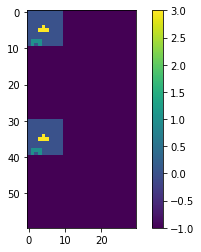

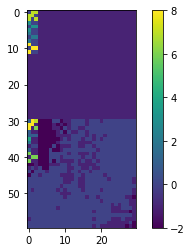

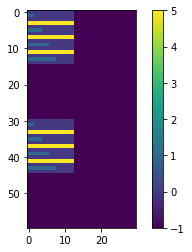

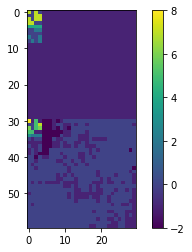

1/1 [==============================] - 327s 327s/step - loss: 0.4148
EPOCH 2 ACCURACY 55.55555555555556


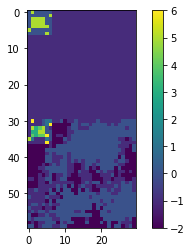

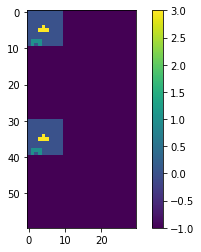

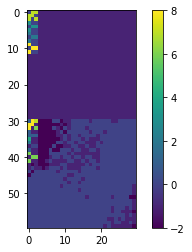

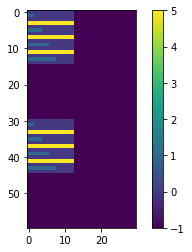

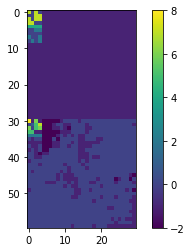

1/1 [==============================] - 328s 328s/step - loss: 0.2925
EPOCH 3 ACCURACY 83.33333333333333


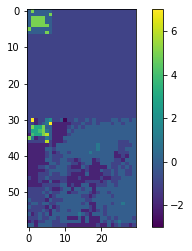

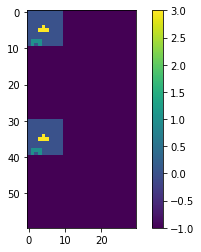

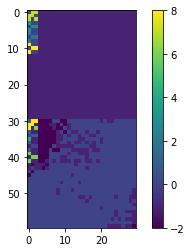

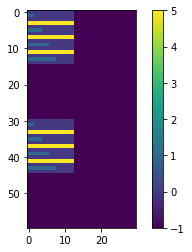

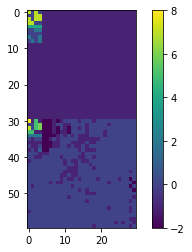

1/1 [==============================] - 327s 327s/step - loss: 0.4880
EPOCH 4 ACCURACY 83.33333333333333


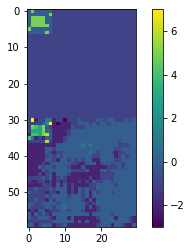

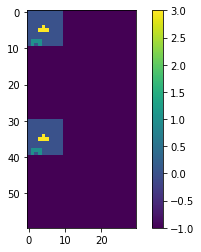

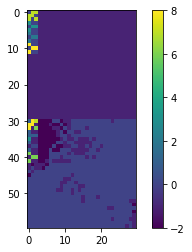

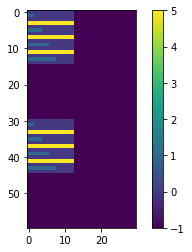

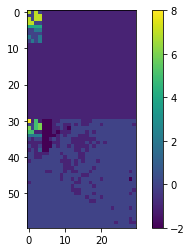

1/1 [==============================] - 327s 327s/step - loss: 0.4457
EPOCH 5 ACCURACY 83.33333333333333


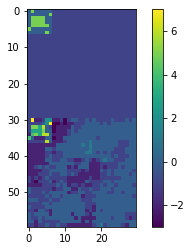

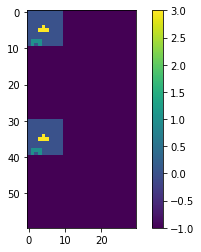

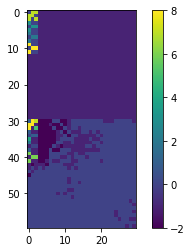

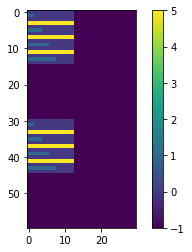

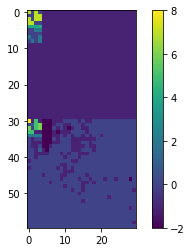

1/1 [==============================] - 327s 327s/step - loss: 0.5282
EPOCH 6 ACCURACY 94.44444444444444


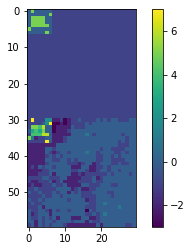

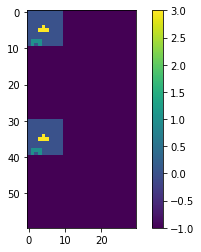

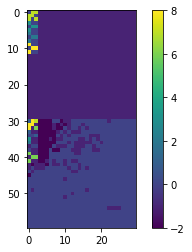

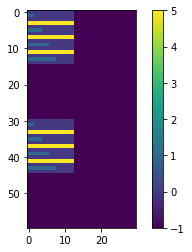

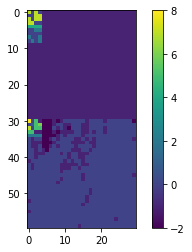

1/1 [==============================] - 327s 327s/step - loss: 0.4360
EPOCH 7 ACCURACY 83.33333333333333


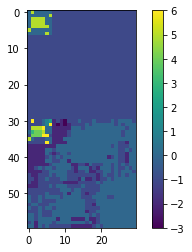

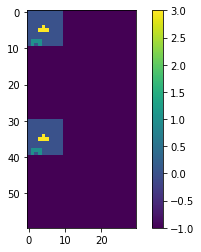

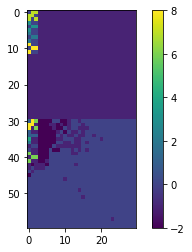

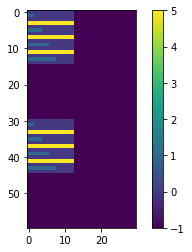

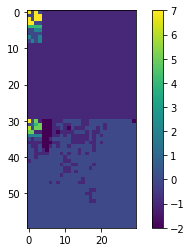

1/1 [==============================] - 326s 326s/step - loss: 0.4024
EPOCH 8 ACCURACY 50.0


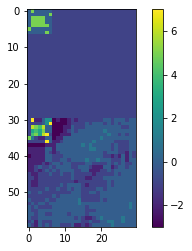

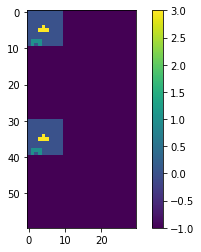

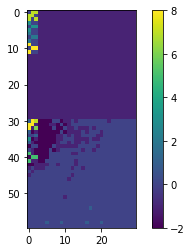

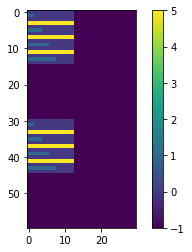

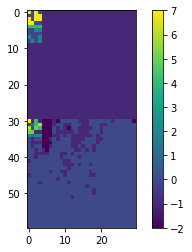

1/1 [==============================] - 325s 325s/step - loss: 0.3320
EPOCH 9 ACCURACY 61.111111111111114


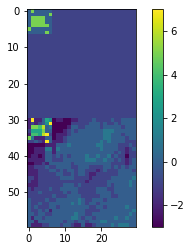

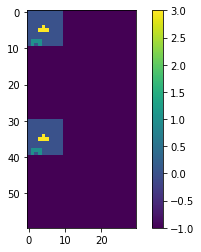

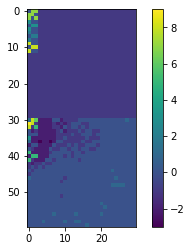

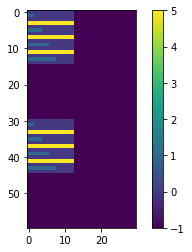

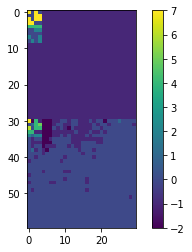

1/1 [==============================] - 325s 325s/step - loss: 0.2981
EPOCH 10 ACCURACY 94.44444444444444


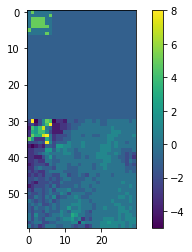

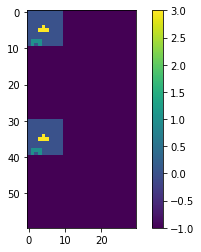

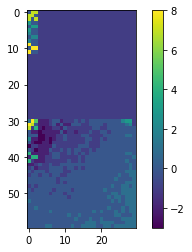

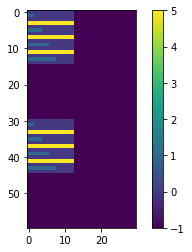

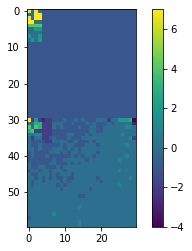

1/1 [==============================] - 322s 322s/step - loss: 0.4319
EPOCH 11 ACCURACY 77.77777777777777


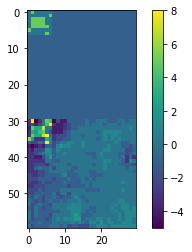

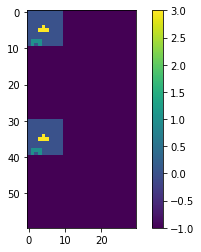

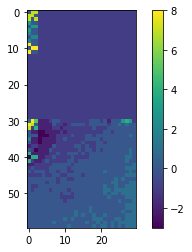

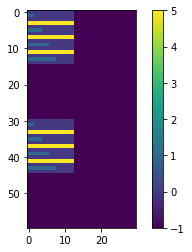

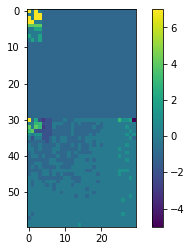

1/1 [==============================] - 322s 322s/step - loss: 0.6781
EPOCH 12 ACCURACY 83.33333333333333


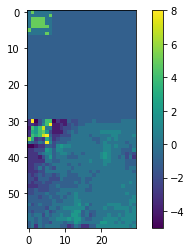

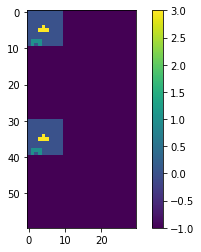

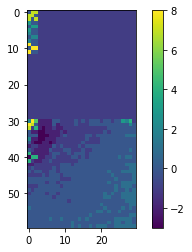

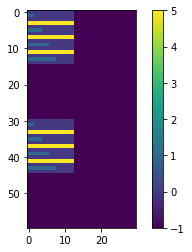

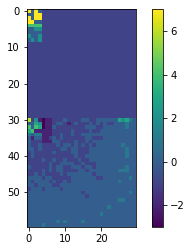

1/1 [==============================] - 322s 322s/step - loss: 0.4596
EPOCH 13 ACCURACY 66.66666666666667


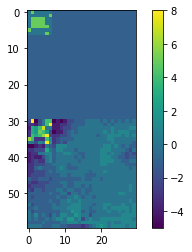

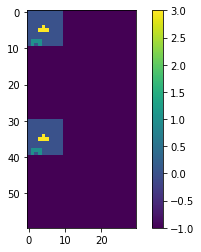

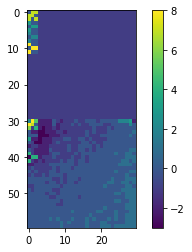

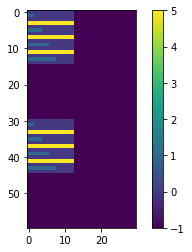

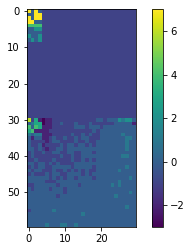

1/1 [==============================] - 322s 322s/step - loss: 0.3734
EPOCH 14 ACCURACY 66.66666666666667


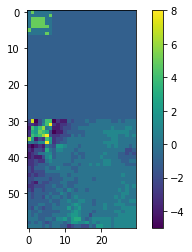

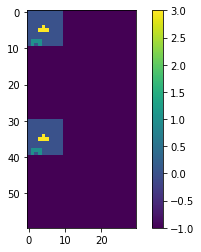

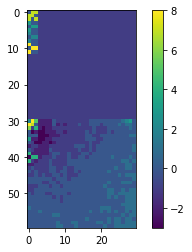

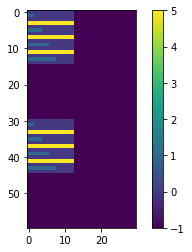

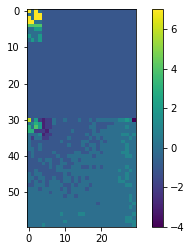

1/1 [==============================] - 322s 322s/step - loss: 0.4746
EPOCH 15 ACCURACY 66.66666666666667


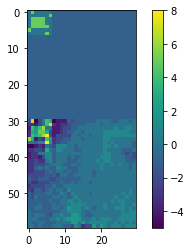

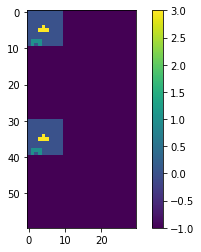

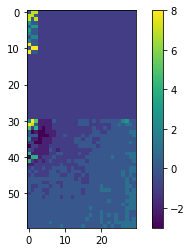

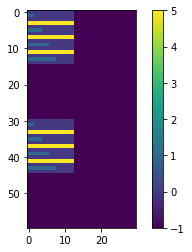

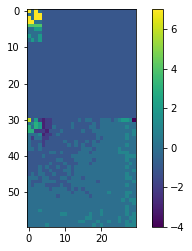

1/1 [==============================] - 322s 322s/step - loss: 0.4657
EPOCH 16 ACCURACY 77.77777777777777


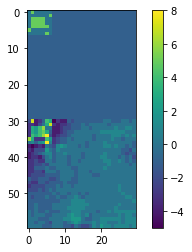

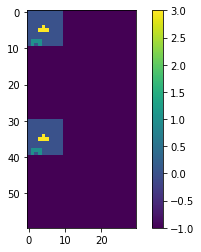

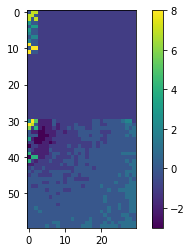

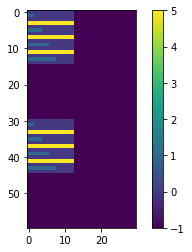

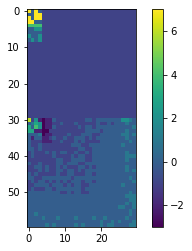

1/1 [==============================] - 322s 322s/step - loss: 0.4274
EPOCH 17 ACCURACY 61.111111111111114


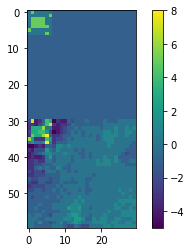

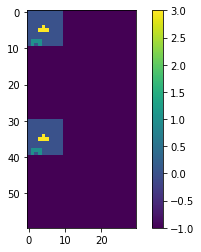

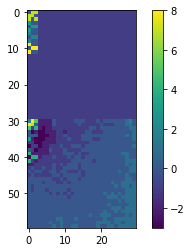

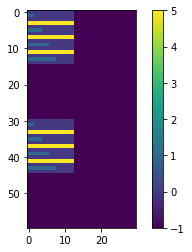

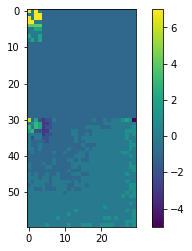

1/1 [==============================] - 322s 322s/step - loss: 0.3530
EPOCH 18 ACCURACY 77.77777777777777


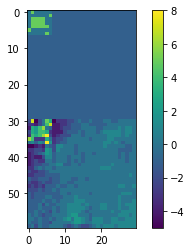

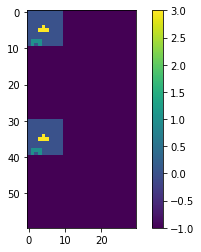

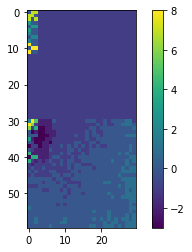

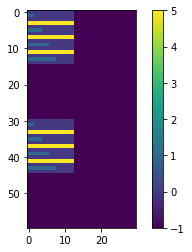

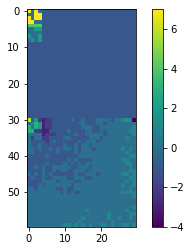

1/1 [==============================] - 322s 322s/step - loss: 0.3866
EPOCH 19 ACCURACY 66.66666666666667


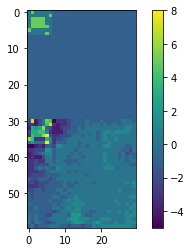

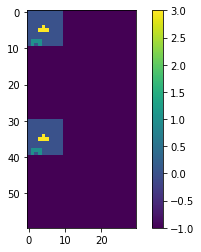

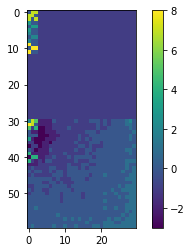

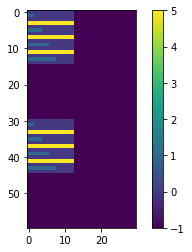

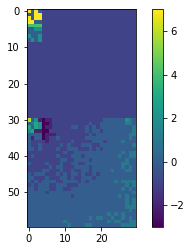

1/1 [==============================] - 322s 322s/step - loss: 0.4287
EPOCH 20 ACCURACY 88.88888888888889


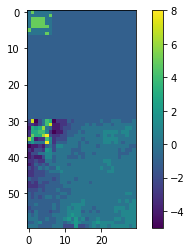

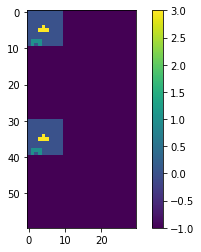

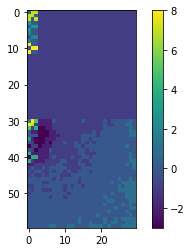

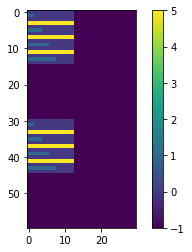

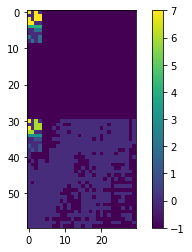

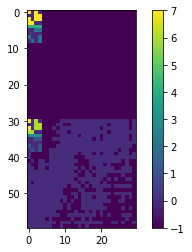

1/1 [==============================] - 322s 322s/step - loss: 0.3362
EPOCH 22 ACCURACY 83.33333333333333


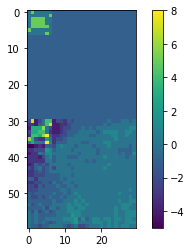

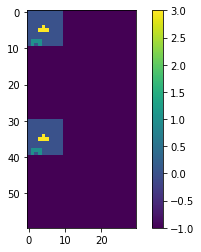

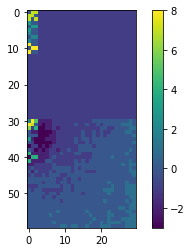

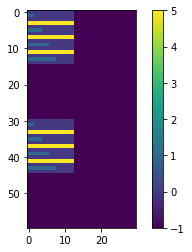

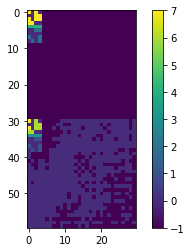

1/1 [==============================] - 322s 322s/step - loss: 0.4107
EPOCH 23 ACCURACY 66.66666666666667


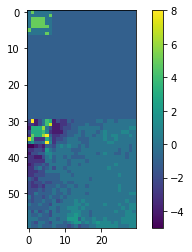

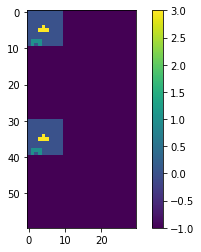

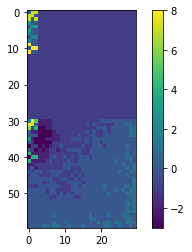

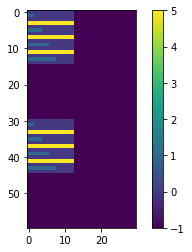

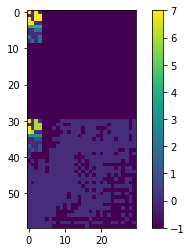

1/1 [==============================] - 322s 322s/step - loss: 0.4231
EPOCH 24 ACCURACY 55.55555555555556


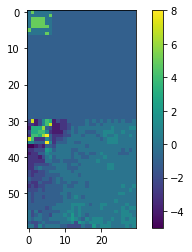

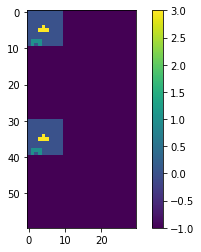

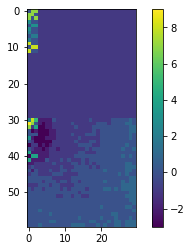

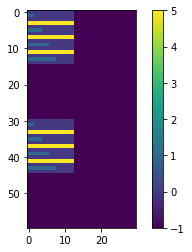

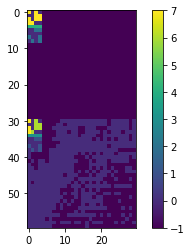

1/1 [==============================] - 322s 322s/step - loss: 0.3845
EPOCH 25 ACCURACY 61.111111111111114


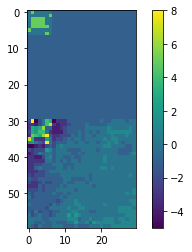

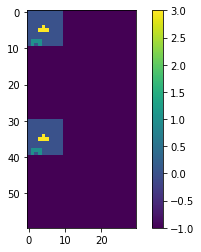

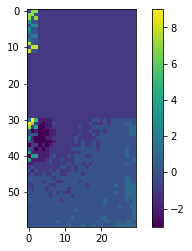

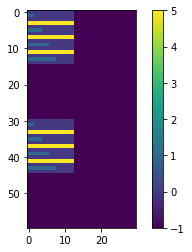

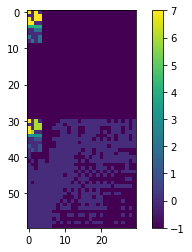

1/1 [==============================] - 322s 322s/step - loss: 0.4109
EPOCH 26 ACCURACY 77.77777777777777


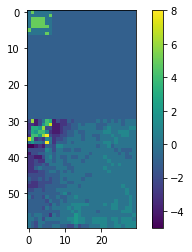

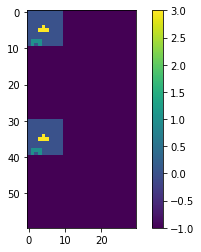

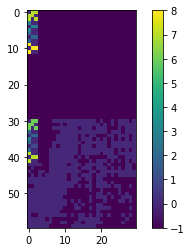

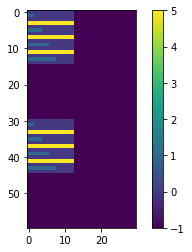

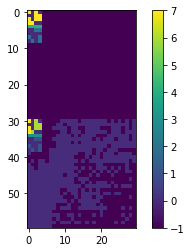

1/1 [==============================] - 322s 322s/step - loss: 0.3436
EPOCH 27 ACCURACY 72.22222222222223


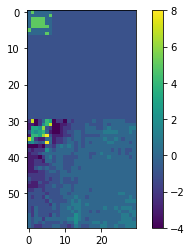

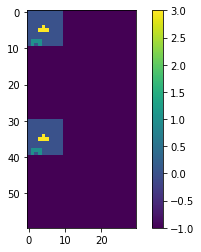

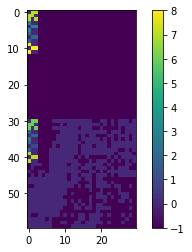

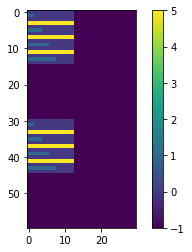

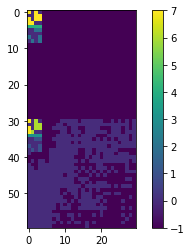

1/1 [==============================] - 322s 322s/step - loss: 0.4101
EPOCH 28 ACCURACY 66.66666666666667


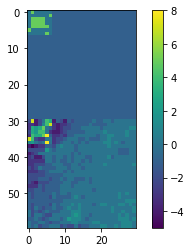

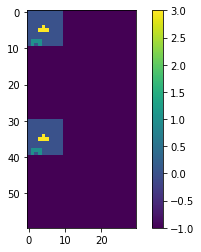

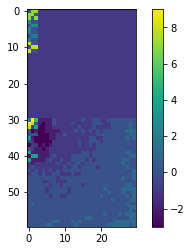

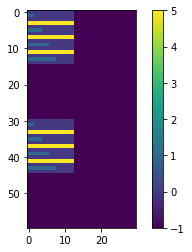

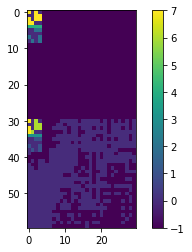

1/1 [==============================] - 322s 322s/step - loss: 0.4353
EPOCH 29 ACCURACY 72.22222222222223


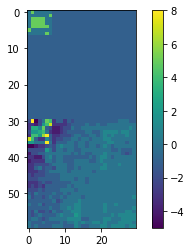

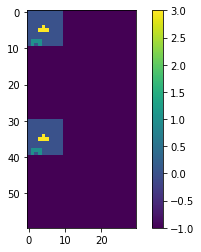

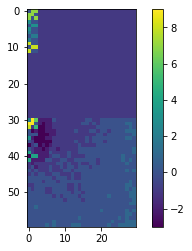

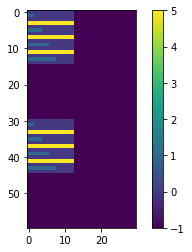

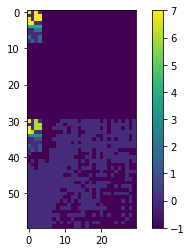

1/1 [==============================] - 322s 322s/step - loss: 0.3696
EPOCH 30 ACCURACY 61.111111111111114


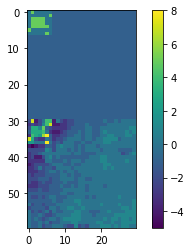

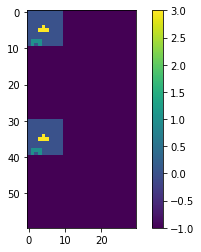

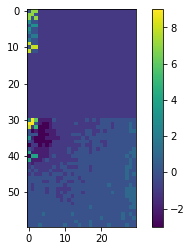

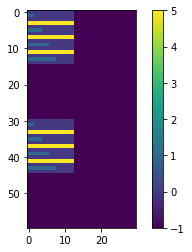

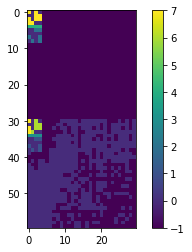

1/1 [==============================] - 322s 322s/step - loss: 0.3279
EPOCH 31 ACCURACY 66.66666666666667


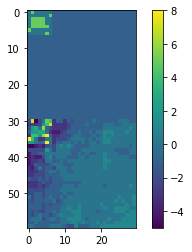

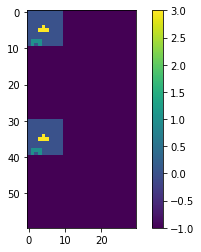

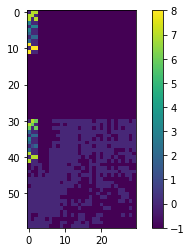

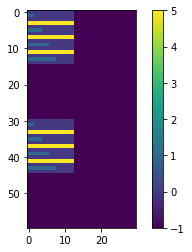

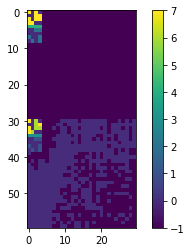

1/1 [==============================] - 322s 322s/step - loss: 0.3948
EPOCH 32 ACCURACY 61.111111111111114


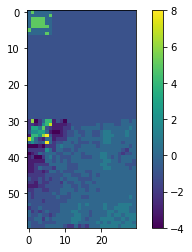

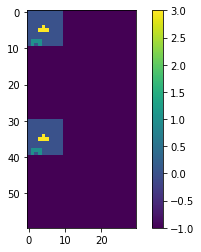

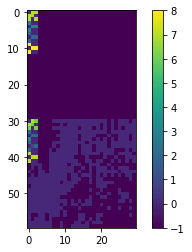

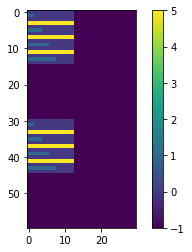

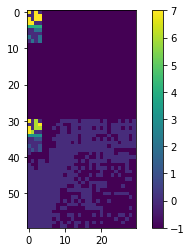

1/1 [==============================] - 322s 322s/step - loss: 0.4158
EPOCH 33 ACCURACY 61.111111111111114


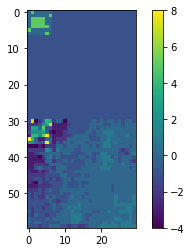

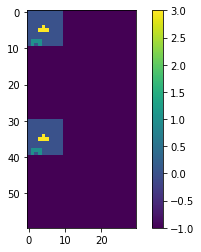

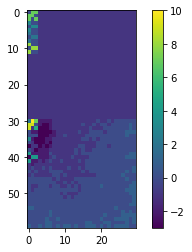

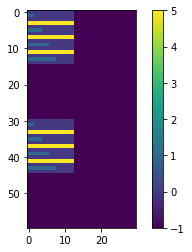

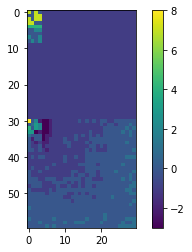

1/1 [==============================] - 322s 322s/step - loss: 0.3507
EPOCH 34 ACCURACY 83.33333333333333


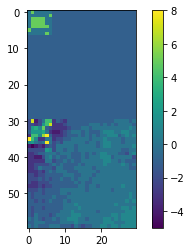

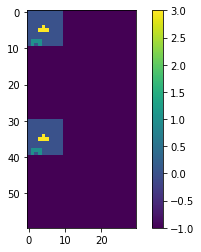

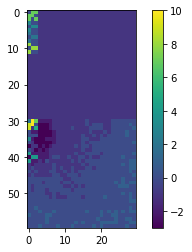

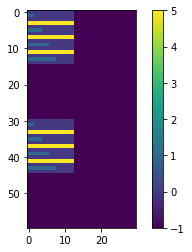

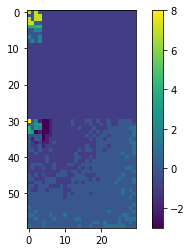

1/1 [==============================] - 322s 322s/step - loss: 0.4089
EPOCH 35 ACCURACY 77.77777777777777


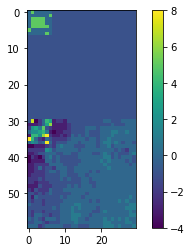

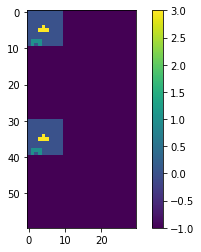

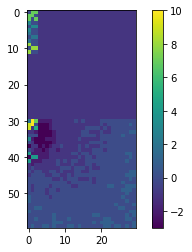

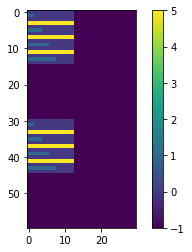

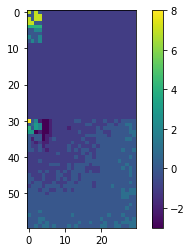

1/1 [==============================] - 322s 322s/step - loss: 0.3449
EPOCH 36 ACCURACY 94.44444444444444


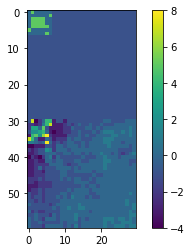

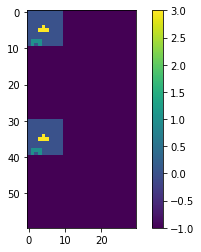

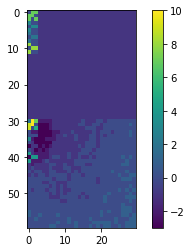

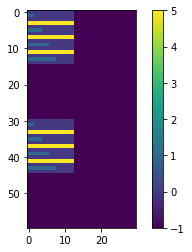

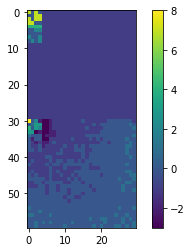

1/1 [==============================] - 322s 322s/step - loss: 0.3057
EPOCH 37 ACCURACY 61.111111111111114


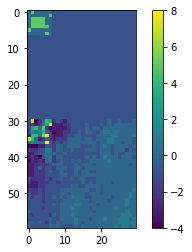

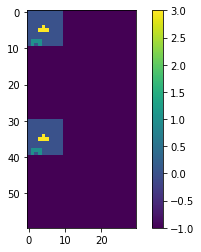

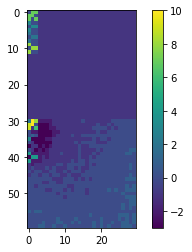

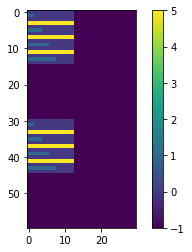

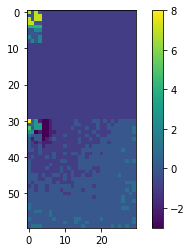

1/1 [==============================] - 322s 322s/step - loss: 0.2847
EPOCH 38 ACCURACY 55.55555555555556


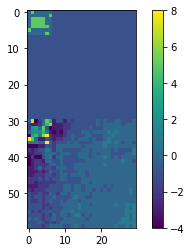

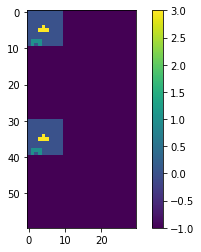

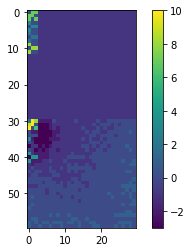

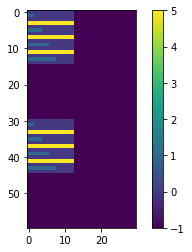

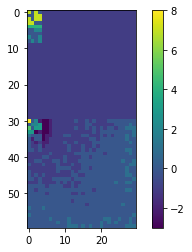

1/1 [==============================] - 322s 322s/step - loss: 0.3411
EPOCH 39 ACCURACY 66.66666666666667


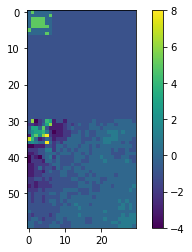

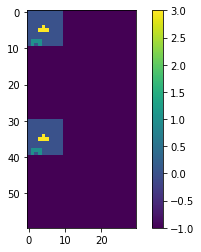

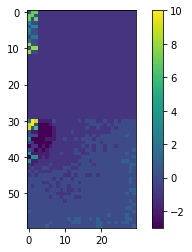

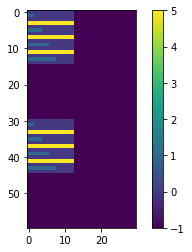

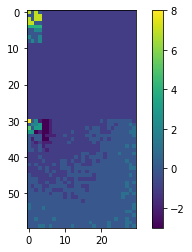

1/1 [==============================] - 322s 322s/step - loss: 0.3538
EPOCH 40 ACCURACY 88.88888888888889


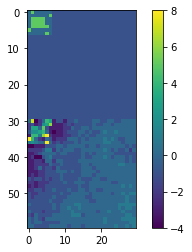

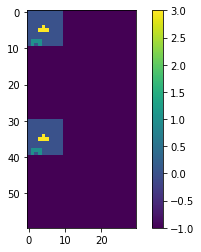

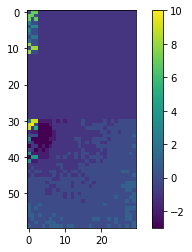

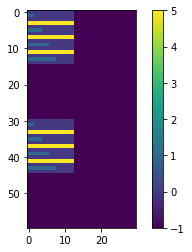

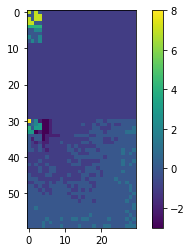

1/1 [==============================] - 322s 322s/step - loss: 0.3560
EPOCH 41 ACCURACY 66.66666666666667


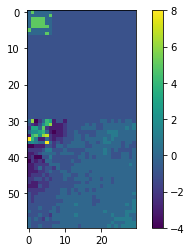

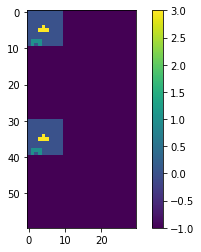

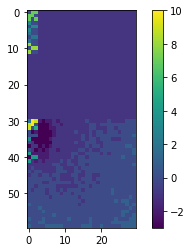

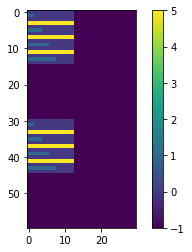

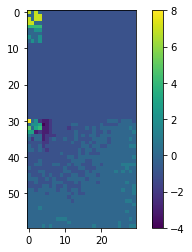

1/1 [==============================] - 322s 322s/step - loss: 0.3263
EPOCH 42 ACCURACY 77.77777777777777


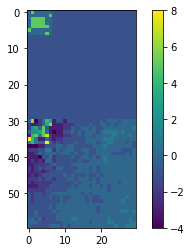

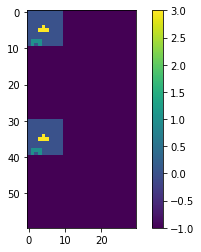

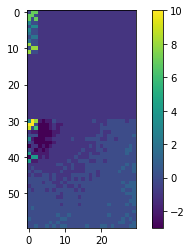

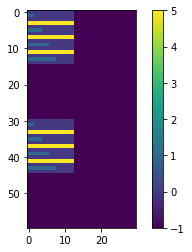

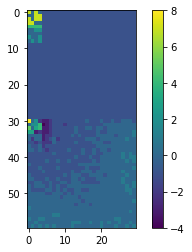

1/1 [==============================] - 322s 322s/step - loss: 0.3014
EPOCH 43 ACCURACY 77.77777777777777


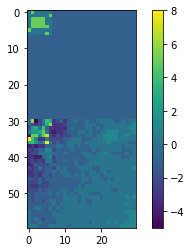

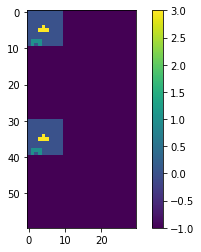

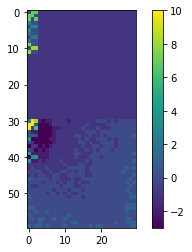

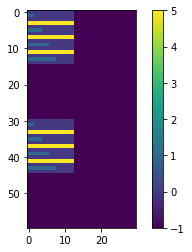

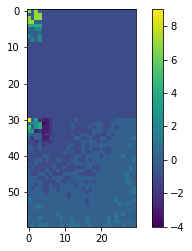

1/1 [==============================] - 322s 322s/step - loss: 0.2728
EPOCH 44 ACCURACY 94.44444444444444


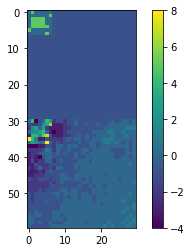

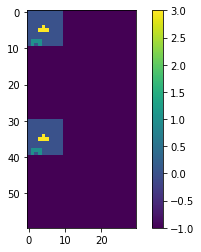

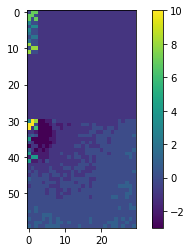

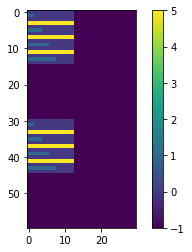

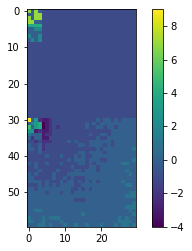

1/1 [==============================] - 322s 322s/step - loss: 0.2326
EPOCH 45 ACCURACY 72.22222222222223


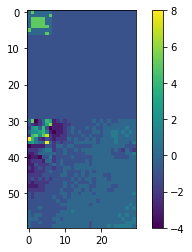

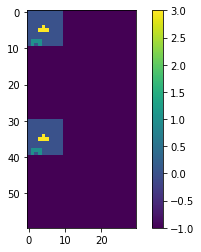

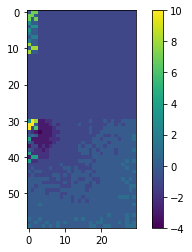

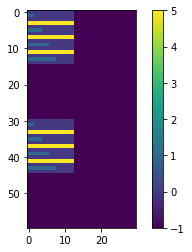

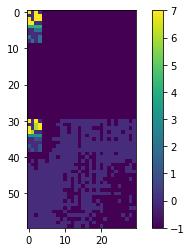

1/1 [==============================] - 322s 322s/step - loss: 0.2838
EPOCH 46 ACCURACY 72.22222222222223


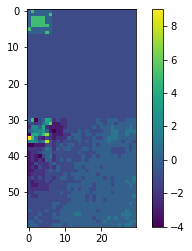

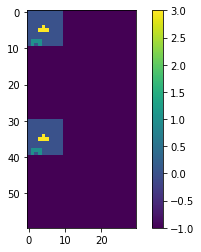

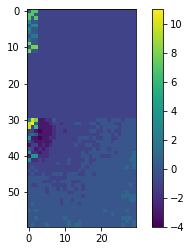

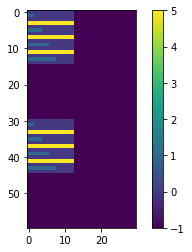

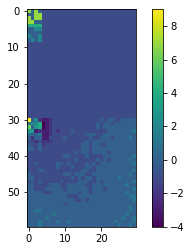

1/1 [==============================] - 322s 322s/step - loss: 0.2708
EPOCH 47 ACCURACY 66.66666666666667


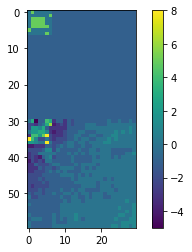

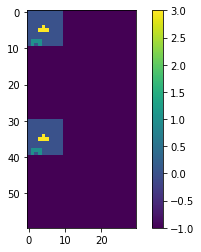

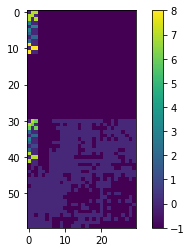

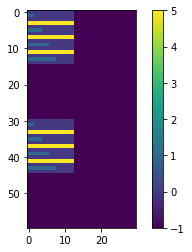

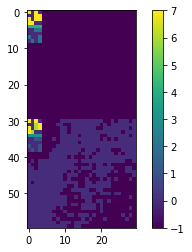

1/1 [==============================] - 322s 322s/step - loss: 0.3065
EPOCH 48 ACCURACY 77.77777777777777


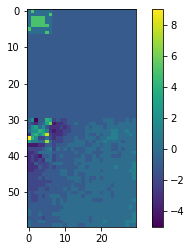

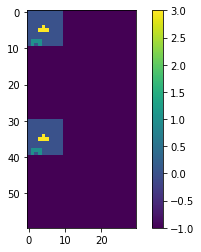

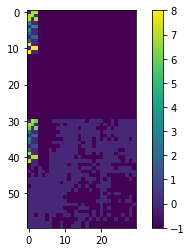

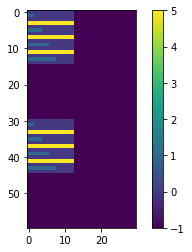

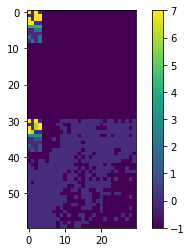

1/1 [==============================] - 322s 322s/step - loss: 0.2778
EPOCH 49 ACCURACY 72.22222222222223


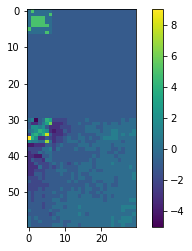

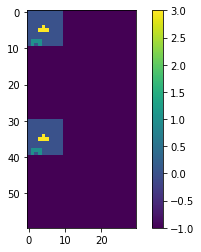

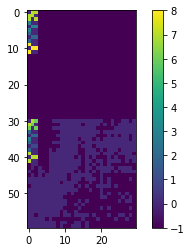

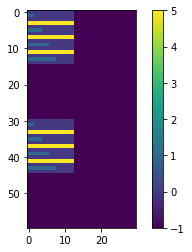

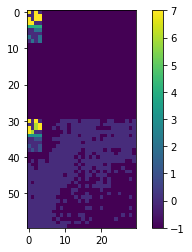

1/1 [==============================] - 322s 322s/step - loss: 0.3087
EPOCH 50 ACCURACY 66.66666666666667


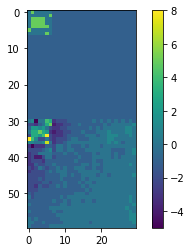

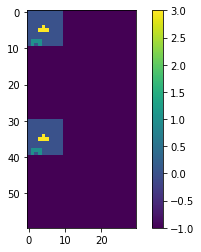

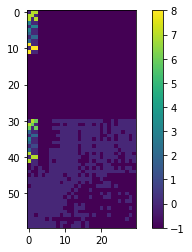

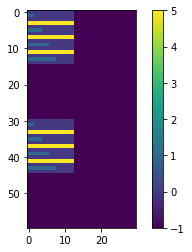

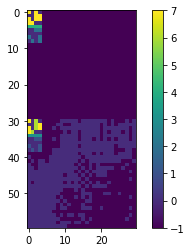

1/1 [==============================] - 322s 322s/step - loss: 0.3340
EPOCH 51 ACCURACY 77.77777777777777


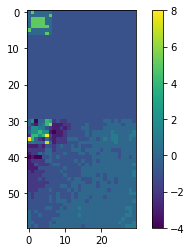

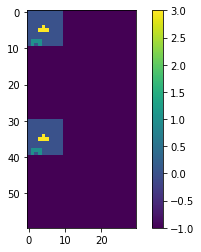

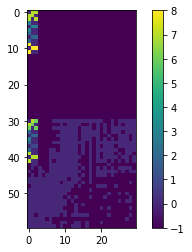

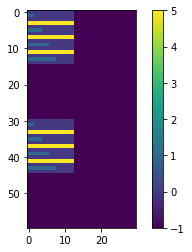

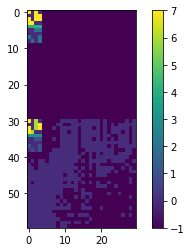

1/1 [==============================] - 322s 322s/step - loss: 0.3269
EPOCH 52 ACCURACY 72.22222222222223


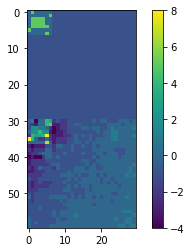

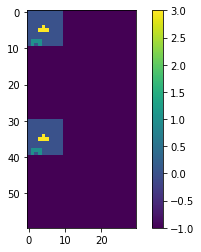

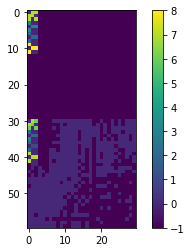

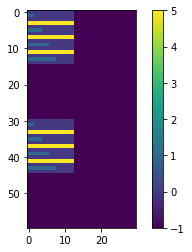

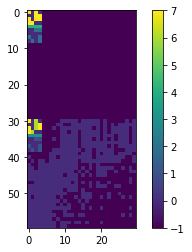

1/1 [==============================] - 322s 322s/step - loss: 0.2404
EPOCH 53 ACCURACY 72.22222222222223


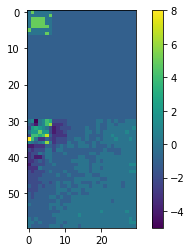

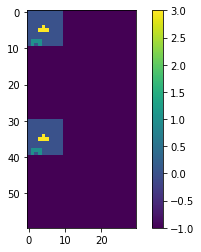

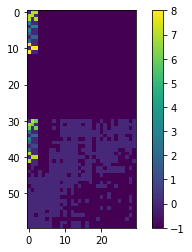

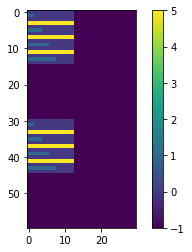

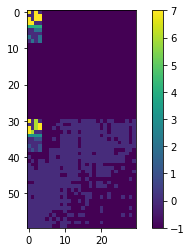

1/1 [==============================] - 322s 322s/step - loss: 0.2748
EPOCH 54 ACCURACY 61.111111111111114


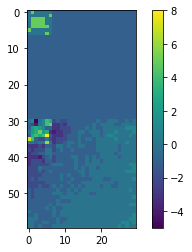

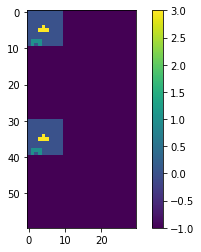

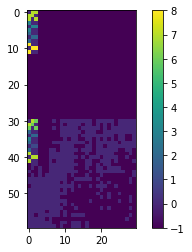

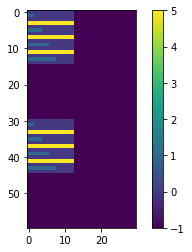

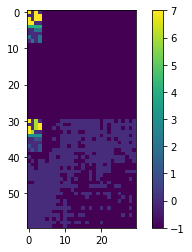

1/1 [==============================] - 322s 322s/step - loss: 0.2271
EPOCH 55 ACCURACY 77.77777777777777


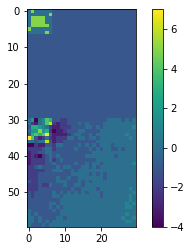

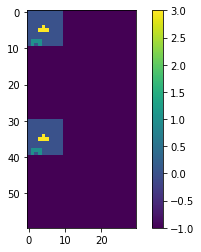

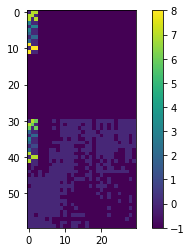

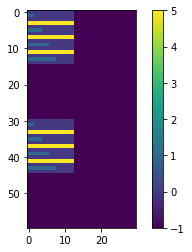

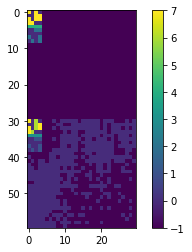

1/1 [==============================] - 322s 322s/step - loss: 0.2314
EPOCH 56 ACCURACY 77.77777777777777


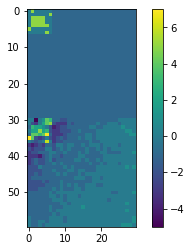

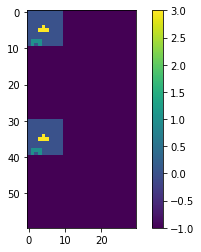

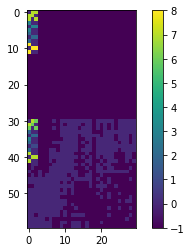

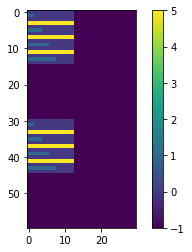

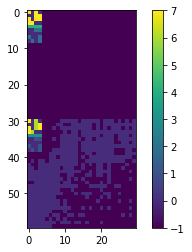

1/1 [==============================] - 322s 322s/step - loss: 0.2543
EPOCH 57 ACCURACY 72.22222222222223


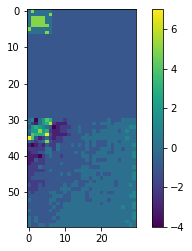

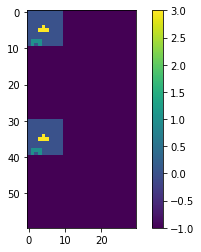

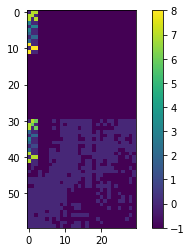

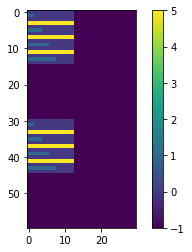

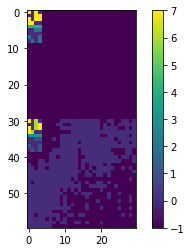

1/1 [==============================] - 322s 322s/step - loss: 0.2790
EPOCH 58 ACCURACY 61.111111111111114


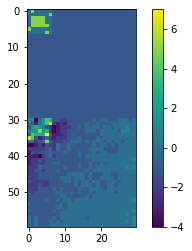

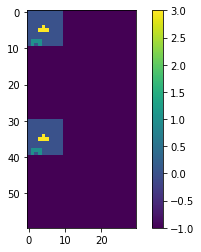

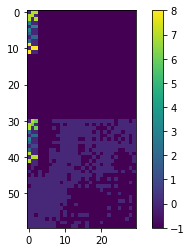

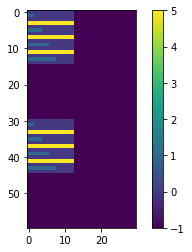

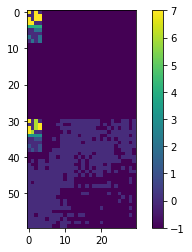

1/1 [==============================] - 322s 322s/step - loss: 0.2263
EPOCH 59 ACCURACY 83.33333333333333


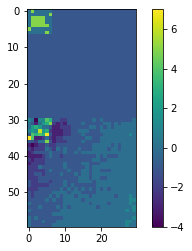

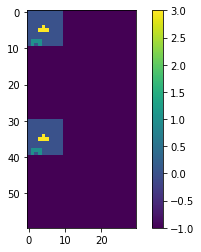

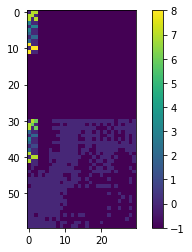

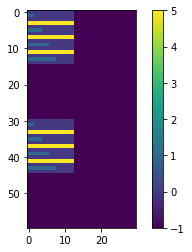

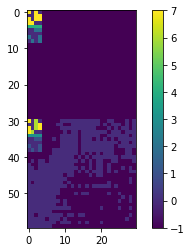

1/1 [==============================] - 322s 322s/step - loss: 0.3013
EPOCH 60 ACCURACY 88.88888888888889


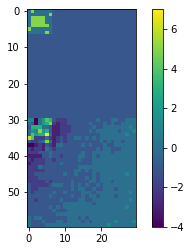

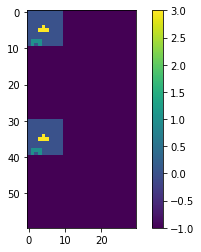

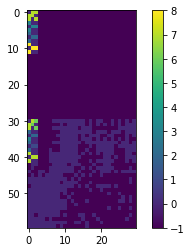

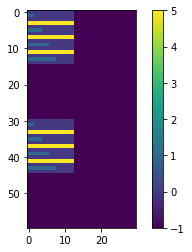

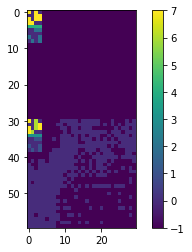

1/1 [==============================] - 322s 322s/step - loss: 0.2844
EPOCH 61 ACCURACY 77.77777777777777


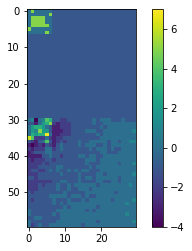

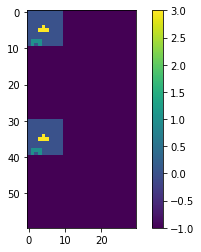

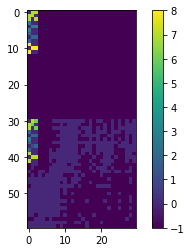

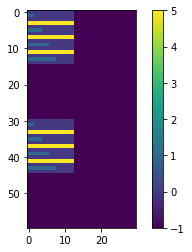

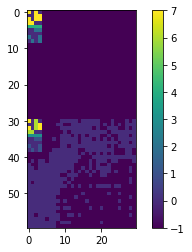

1/1 [==============================] - 322s 322s/step - loss: 0.2724
EPOCH 62 ACCURACY 88.88888888888889


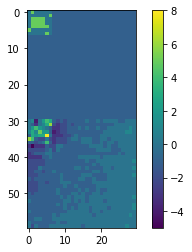

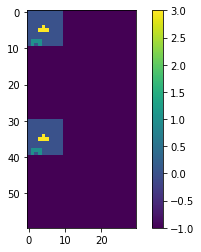

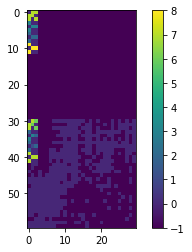

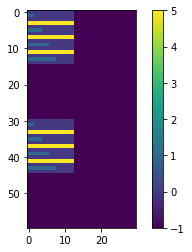

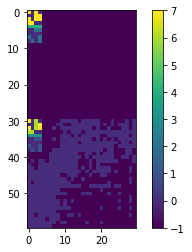

1/1 [==============================] - 322s 322s/step - loss: 0.2600
EPOCH 63 ACCURACY 77.77777777777777


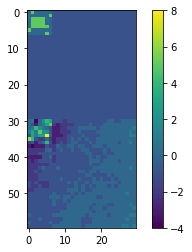

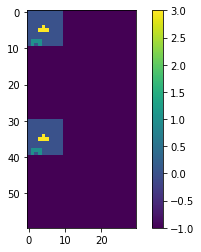

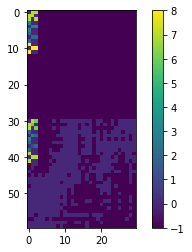

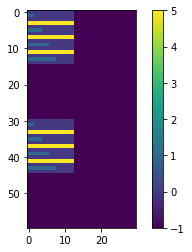

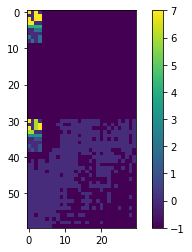

1/1 [==============================] - 322s 322s/step - loss: 0.2810
EPOCH 64 ACCURACY 55.55555555555556


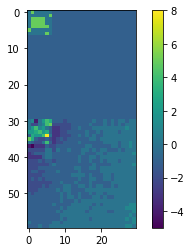

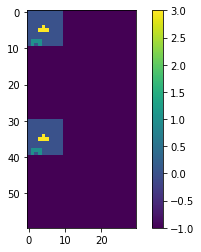

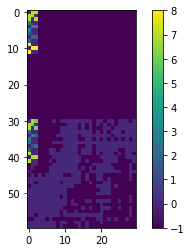

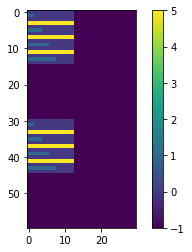

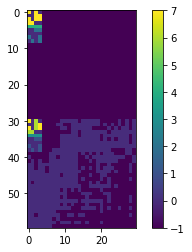

1/1 [==============================] - 322s 322s/step - loss: 0.2929
EPOCH 65 ACCURACY 72.22222222222223


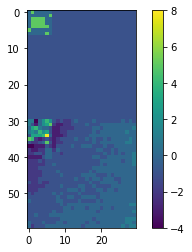

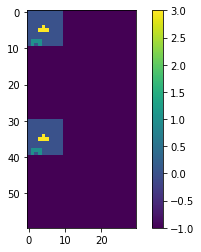

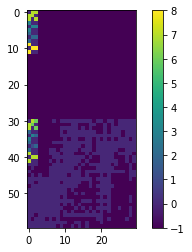

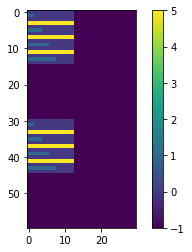

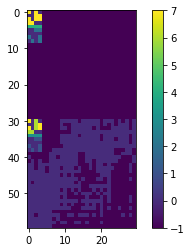

1/1 [==============================] - 322s 322s/step - loss: 0.2172
EPOCH 66 ACCURACY 66.66666666666667


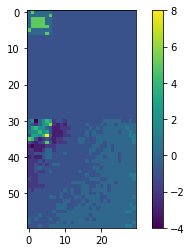

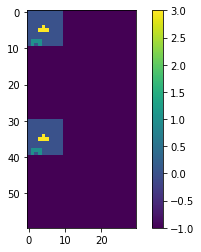

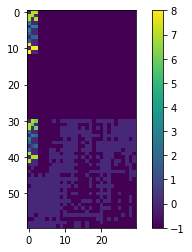

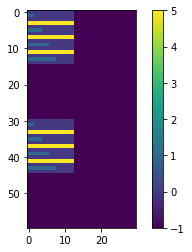

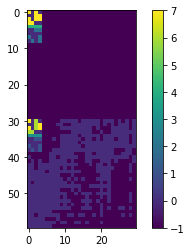

1/1 [==============================] - 322s 322s/step - loss: 0.2206
EPOCH 67 ACCURACY 61.111111111111114


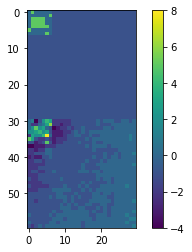

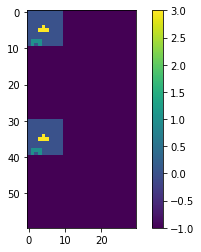

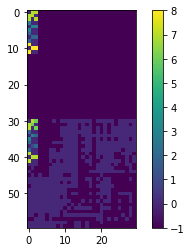

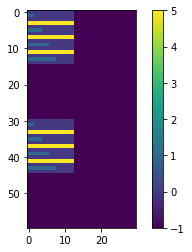

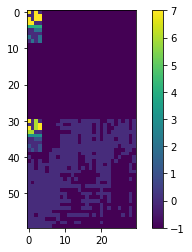

1/1 [==============================] - 322s 322s/step - loss: 0.2266
EPOCH 68 ACCURACY 77.77777777777777


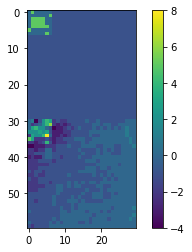

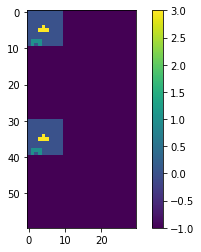

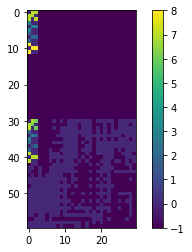

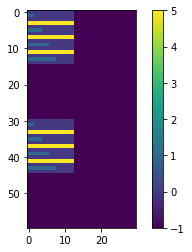

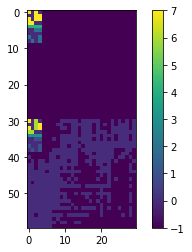

1/1 [==============================] - 322s 322s/step - loss: 0.2169
EPOCH 69 ACCURACY 66.66666666666667


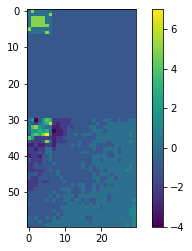

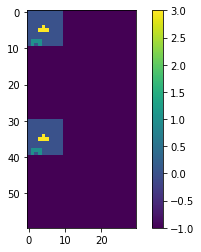

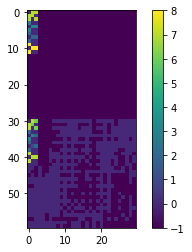

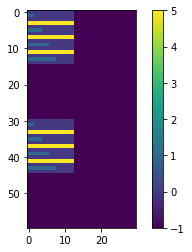

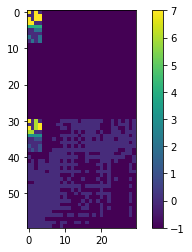

1/1 [==============================] - 322s 322s/step - loss: 0.2035
EPOCH 70 ACCURACY 72.22222222222223


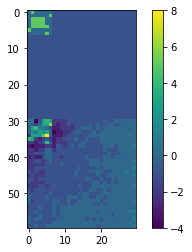

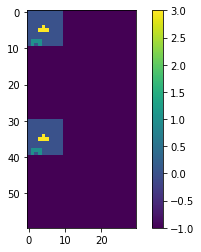

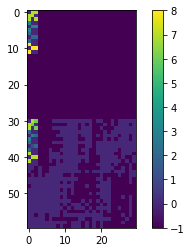

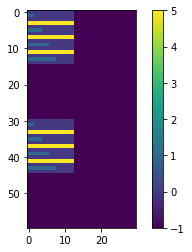

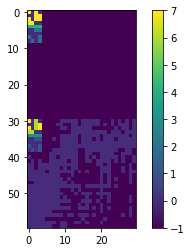

1/1 [==============================] - 322s 322s/step - loss: 0.2367
EPOCH 71 ACCURACY 66.66666666666667


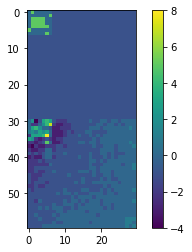

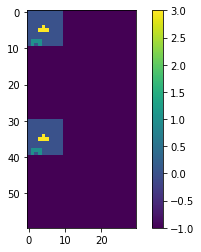

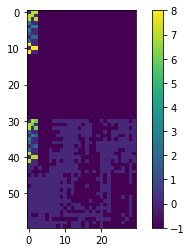

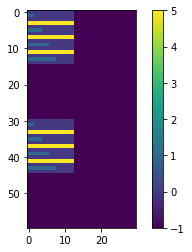

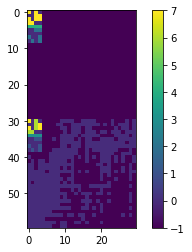

1/1 [==============================] - 322s 322s/step - loss: 0.2181
EPOCH 72 ACCURACY 77.77777777777777


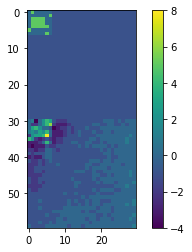

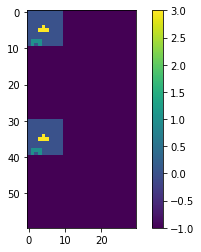

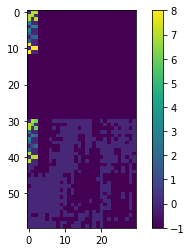

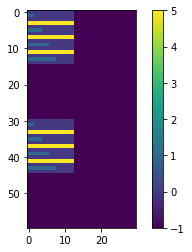

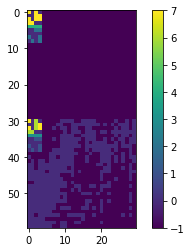

1/1 [==============================] - 322s 322s/step - loss: 0.2896
EPOCH 73 ACCURACY 55.55555555555556


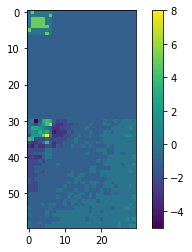

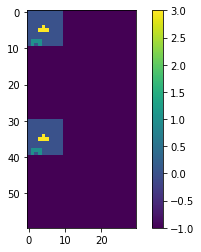

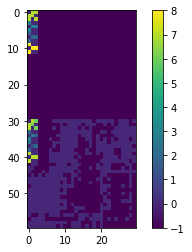

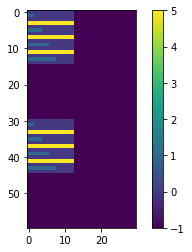

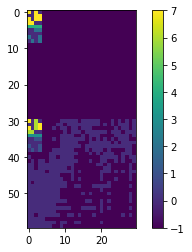

1/1 [==============================] - 322s 322s/step - loss: 0.2259
EPOCH 74 ACCURACY 61.111111111111114


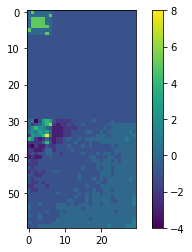

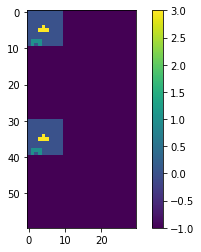

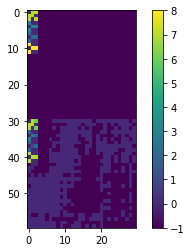

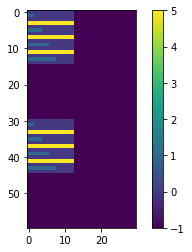

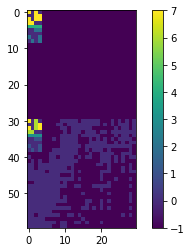

1/1 [==============================] - 322s 322s/step - loss: 0.2223
EPOCH 75 ACCURACY 83.33333333333333


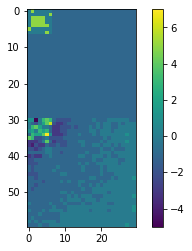

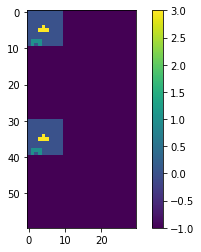

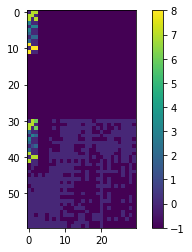

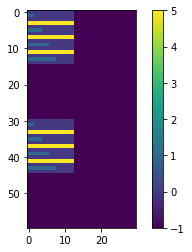

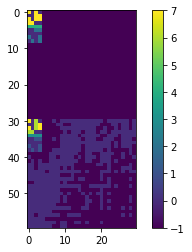

1/1 [==============================] - 322s 322s/step - loss: 0.2105
EPOCH 76 ACCURACY 83.33333333333333


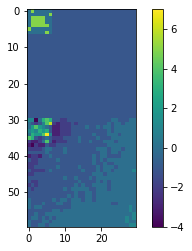

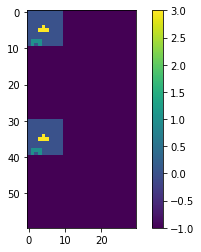

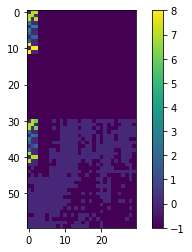

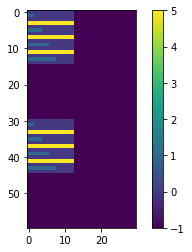

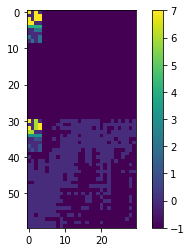

1/1 [==============================] - 322s 322s/step - loss: 0.1969
EPOCH 77 ACCURACY 55.55555555555556


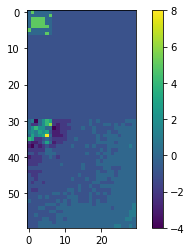

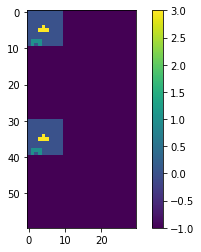

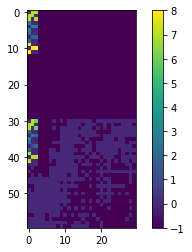

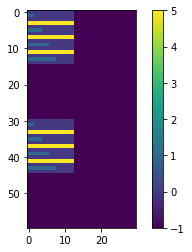

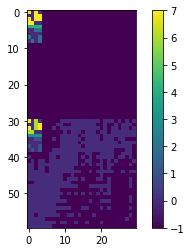

1/1 [==============================] - 322s 322s/step - loss: 0.2269
EPOCH 78 ACCURACY 83.33333333333333


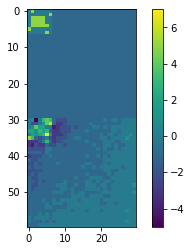

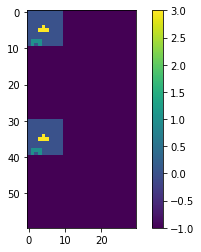

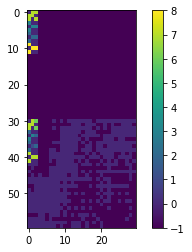

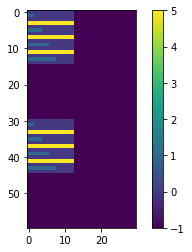

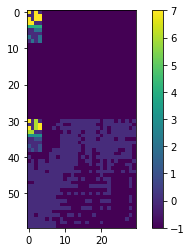

1/1 [==============================] - 317s 317s/step - loss: 0.2669
EPOCH 79 ACCURACY 61.111111111111114


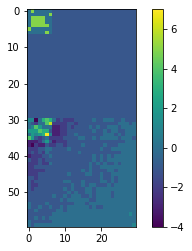

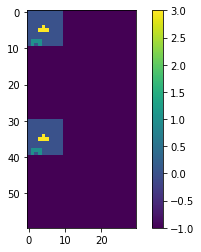

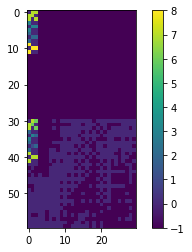

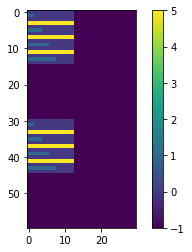

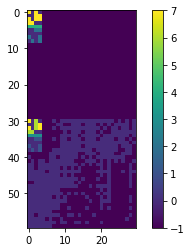

1/1 [==============================] - 322s 322s/step - loss: 0.2081
EPOCH 80 ACCURACY 61.111111111111114


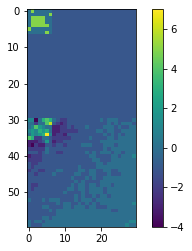

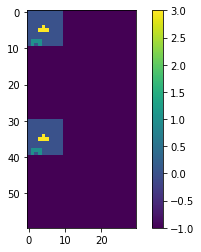

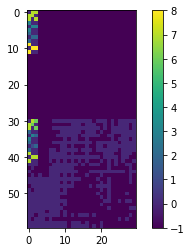

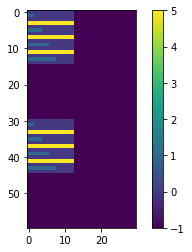

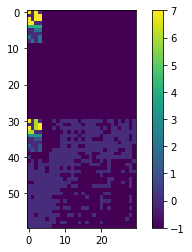

1/1 [==============================] - 322s 322s/step - loss: 0.2329
EPOCH 81 ACCURACY 77.77777777777777


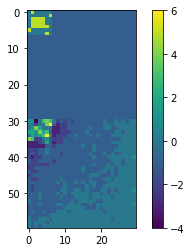

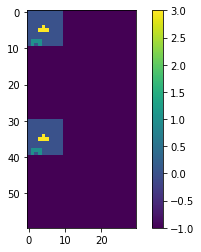

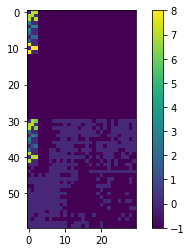

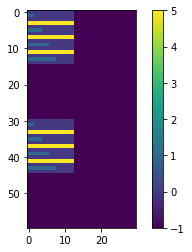

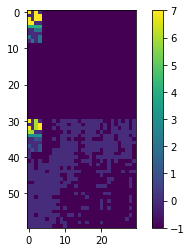

1/1 [==============================] - 322s 322s/step - loss: 0.1821
EPOCH 82 ACCURACY 72.22222222222223


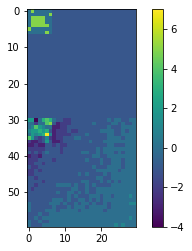

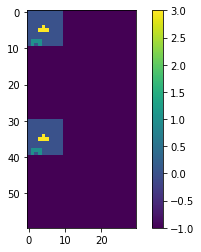

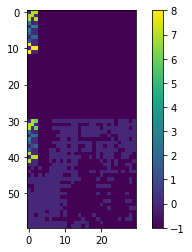

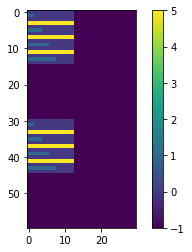

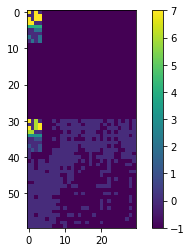

1/1 [==============================] - 322s 322s/step - loss: 0.1908
EPOCH 83 ACCURACY 77.77777777777777


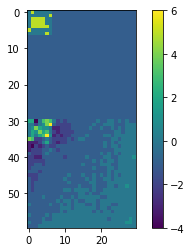

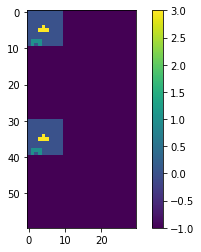

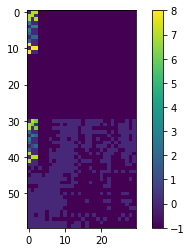

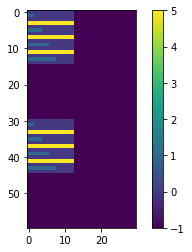

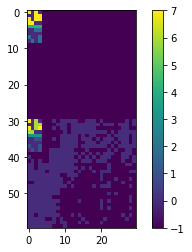

1/1 [==============================] - 317s 317s/step - loss: 0.1960
EPOCH 84 ACCURACY 88.88888888888889


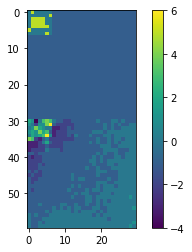

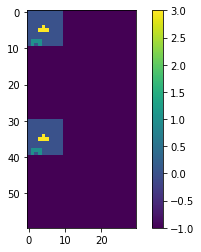

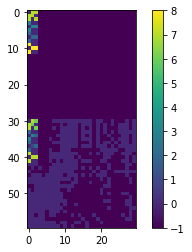

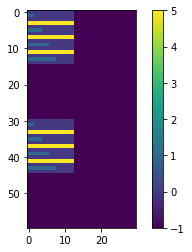

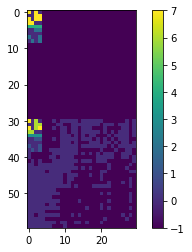

1/1 [==============================] - 322s 322s/step - loss: 0.1741
EPOCH 85 ACCURACY 66.66666666666667


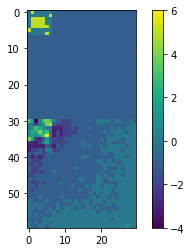

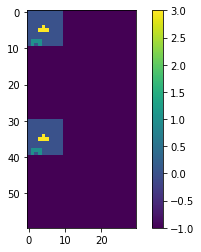

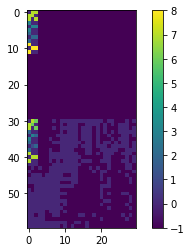

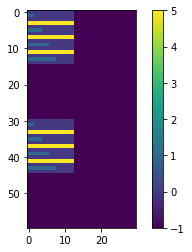

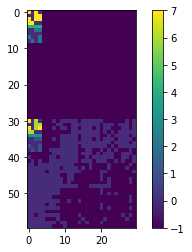

1/1 [==============================] - 322s 322s/step - loss: 0.1772
EPOCH 86 ACCURACY 72.22222222222223


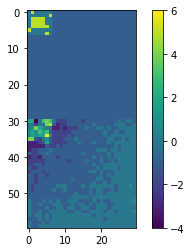

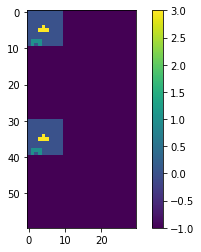

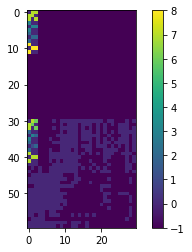

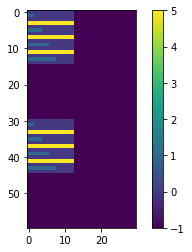

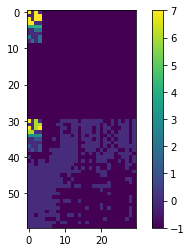

1/1 [==============================] - 322s 322s/step - loss: 0.1913
EPOCH 87 ACCURACY 83.33333333333333


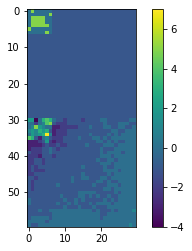

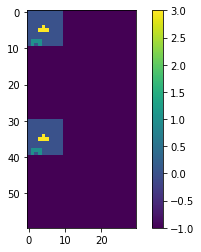

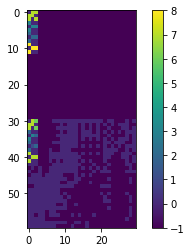

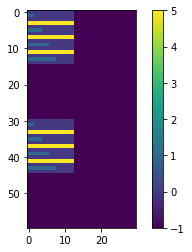

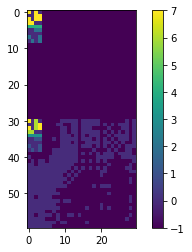

1/1 [==============================] - 322s 322s/step - loss: 0.2147
EPOCH 88 ACCURACY 94.44444444444444


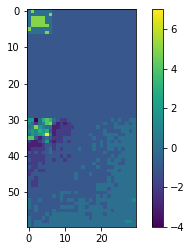

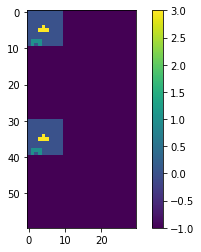

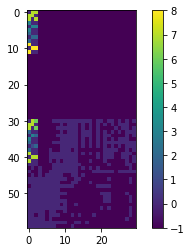

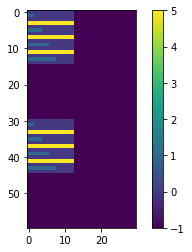

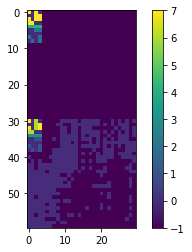

1/1 [==============================] - 317s 317s/step - loss: 0.1650
EPOCH 89 ACCURACY 44.44444444444444


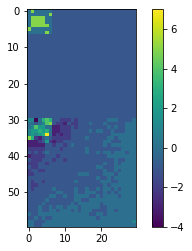

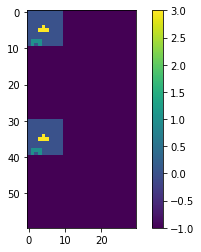

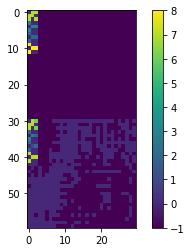

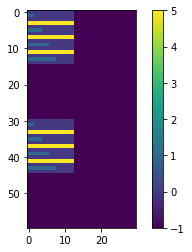

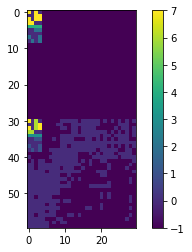

1/1 [==============================] - 307s 307s/step - loss: 0.2130
EPOCH 90 ACCURACY 66.66666666666667


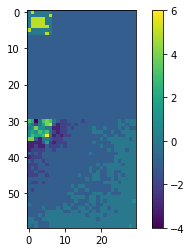

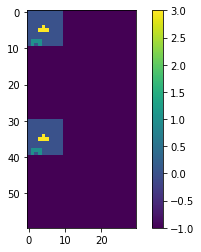

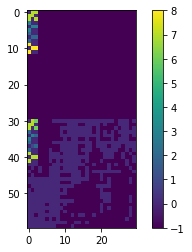

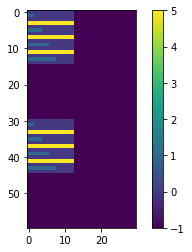

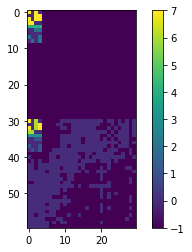

1/1 [==============================] - 322s 322s/step - loss: 0.2073
EPOCH 91 ACCURACY 55.55555555555556


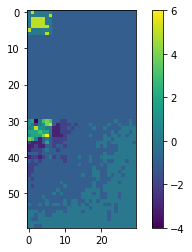

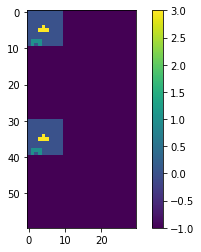

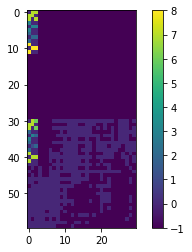

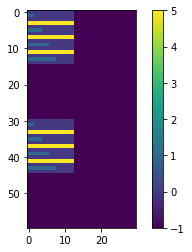

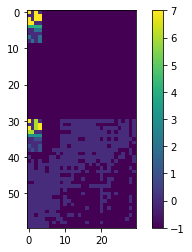

1/1 [==============================] - 322s 322s/step - loss: 0.2274
EPOCH 92 ACCURACY 72.22222222222223


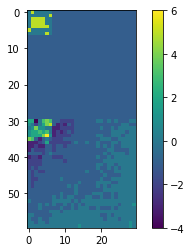

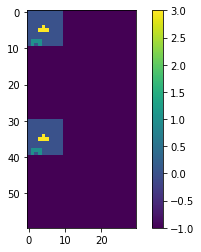

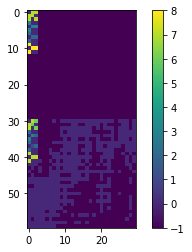

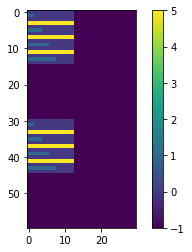

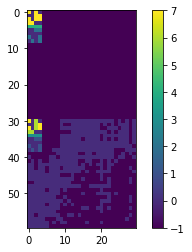

1/1 [==============================] - 322s 322s/step - loss: 0.2465
EPOCH 93 ACCURACY 77.77777777777777


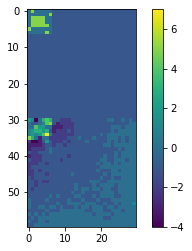

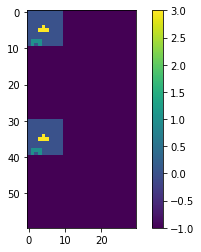

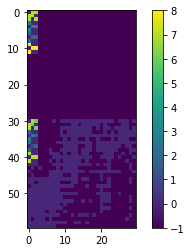

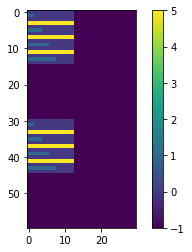

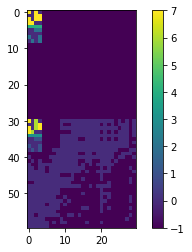

1/1 [==============================] - 322s 322s/step - loss: 0.1956
EPOCH 94 ACCURACY 72.22222222222223


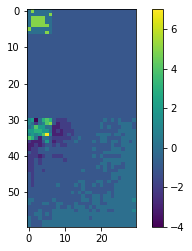

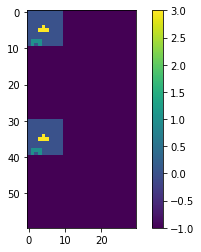

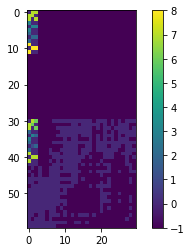

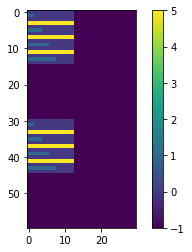

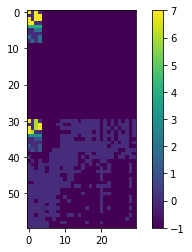

1/1 [==============================] - 322s 322s/step - loss: 0.1941
EPOCH 95 ACCURACY 72.22222222222223


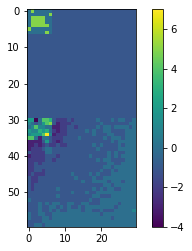

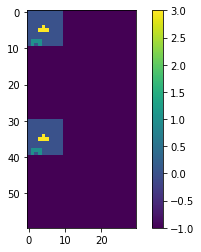

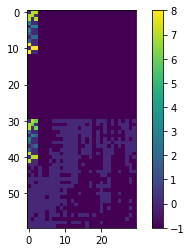

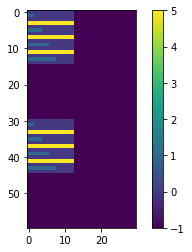

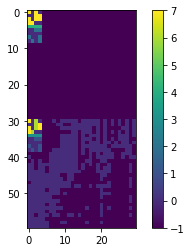

1/1 [==============================] - 317s 317s/step - loss: 0.2231
EPOCH 96 ACCURACY 83.33333333333333


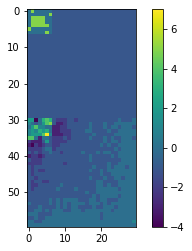

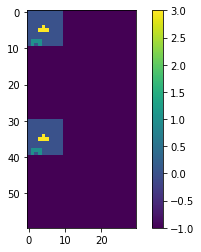

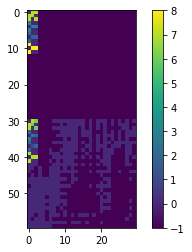

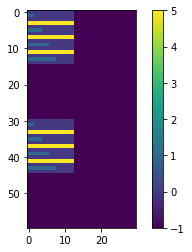

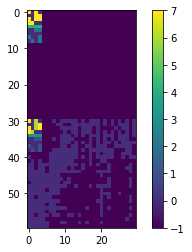

1/1 [==============================] - 322s 322s/step - loss: 0.1667
EPOCH 97 ACCURACY 66.66666666666667


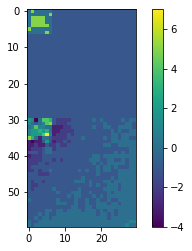

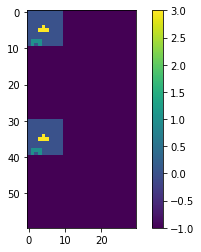

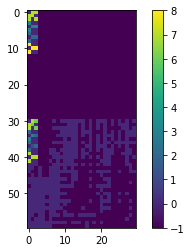

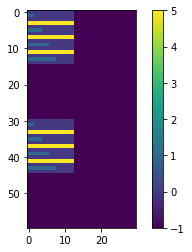

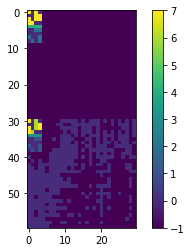

1/1 [==============================] - 317s 317s/step - loss: 0.2149
EPOCH 98 ACCURACY 61.111111111111114


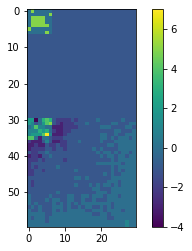

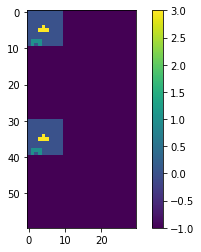

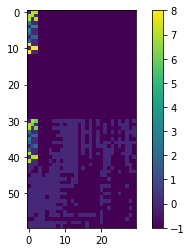

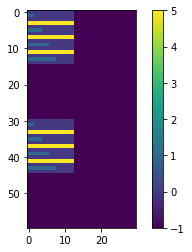

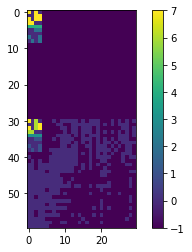

1/1 [==============================] - 322s 322s/step - loss: 0.2018
EPOCH 99 ACCURACY 88.88888888888889


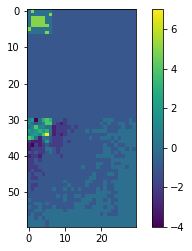

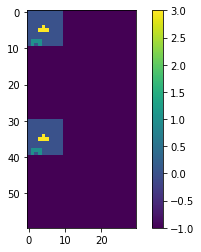

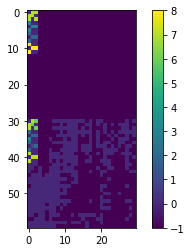

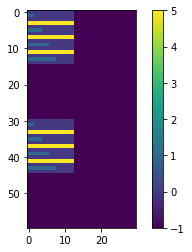

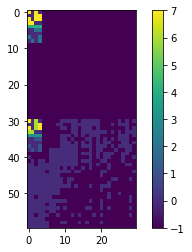

In [319]:
trackedclasses = rng.choice(Xt.shape[0], size=(5,), replace=False)

print("Ground Truth")
for i in trackedclasses:
    correct = Xv[i][0]
    plt.imshow(correct)
    plt.colorbar()
    plt.show()

epo = 100
for i in range(epo):
    model.fit_generator(generateMixed(128, True), epochs=1, steps_per_epoch=1)
    accuracy = testAccuracy(model, 20, 18)
    print("EPOCH "+str(i)+" ACCURACY "+str(accuracy))
    for k in trackedclasses:
        out = generateExample(k, 80, True)
        plt.imshow(out)
        plt.colorbar()
        plt.show()

In [ ]:
taskclass = 5
examples = []
for i in range(Xt[taskclass].shape[0]):
    examples.append(Xt[taskclass][i].reshape(60,30,1).astype(np.float64))
cin = np.array([Xv[taskclass][0].reshape(60,30,1)])
cin[0][30:, :, :] = cin[0][:30, :, :]
generateTaskAdam(examples, cin, 0.5, 80, False)

*OPTIONAL* Test to compare ADAM to Batch Gradient Descent

In [ ]:
cclass = random.randint(0, Xt.shape[0])
t1 = timer()
out = generateExample(cclass, 80, True)
t2 = timer()
outtrad = generateExample(cclass, 80, False)
t3 = timer()
correct = Xv[cclass][0]
print("ADAM took "+str(t2-t1))
plt.imshow(out)
plt.colorbar()
plt.show()
print("Batch Gradient Descent took "+str(t3-t2))
plt.imshow(outtrad)
plt.colorbar()
plt.show()
print("Ground truth")
plt.imshow(correct)
plt.colorbar()
plt.show()

*OPTIONAL* Test to calculate average time

In [ ]:
cclass = random.randint(0, Xt.shape[0])
ttimes = 0
cycles = 40
for i in range(cycles):
    cclass = random.randint(0, Xt.shape[0]-1)
    t1 = timer()
    out = generateExample(cclass, 80, True)
    t2 = timer()
    ttimes += t2-t1
    print(t2-t1)
avgtime = ttimes/cycles
print("AVERAGE TIME "+str(avgtime))

In [ ]:
Xadv = []
Yadv = []
for i in range(Xt.shape[0]):

500
2


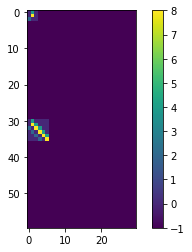

In [188]:
print(Xt.shape[0])
n = 170
print(len(Xt[n]))
plt.imshow(Xt[n][1].reshape(60, 30))
plt.colorbar()
plt.show()

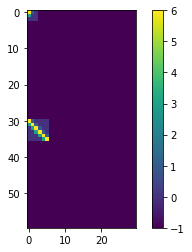

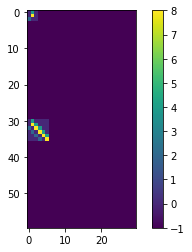

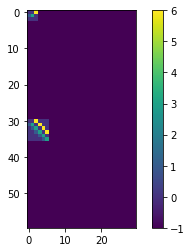

In [189]:
plt.imshow(Xt[n][0].reshape(60, 30))
plt.colorbar()
plt.show()
plt.imshow(Xt[n][1].reshape(60, 30))
plt.colorbar()
plt.show()
plt.imshow(Xv[n][0].reshape(60, 30))
plt.colorbar()
plt.show()
examples = [Xt[n][0].reshape(60,30,1).astype(np.float64), Xt[n][1].reshape(60,30,1).astype(np.float64)] 
cin = np.array([Xv[n][0].reshape(60,30,1)])
cin[0][30:, :, :] = cin[0][:30, :, :]
#cin[0][30:, :, :] = np.random.randint(-1, 10, size=(30, 30, 1))
#cin[0][30:, :, :] = np.zeros((30, 30, 1))
#sampletask[1][0][30:, :, :] = np.random.randint(-1, 11, size=(30, 30, 1))
#plt.imshow(cin.reshape(60, 30))
#plt.colorbar()
#plt.show()
#out = generateTask(examples, cin, 10, 40000)
#plt.imshow(out)
#plt.colorbar()
#plt.show()